<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90"></div></a>

# Hadoop single-node cluster setup with Python
<br>
<br>

Following Apache's official documentation [Hadoop: Setting up a Single Node Cluster](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/SingleCluster.html) we are going to launch a single node Hadoop cluster in _pseudo-distributed_ mode [Pseudo-Distributed Operation](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/SingleCluster.html#Pseudo-Distributed_Operation). As opposed to single-node local (standalone) operation where one single Java Virtual Machine is responsible for all services, in the pseudo-distributed mode each Hadoop daemon runs in a separate Java process.

In this notebook, we are going to rely as much as possible Python commands. This is the companion notebook to [Hadoop Setting up a Single Node Cluster](https://github.com/groda/big_data/blob/master/Hadoop_Setting_up_a_Single_Node_Cluster.ipynb), implemented in bash.

>[Hadoop single-node cluster setup with Python](#scrollTo=_7teiy-B-x8F)

>[About this tutorial](#scrollTo=2CBLhsV-KXNS)

>[Constants](#scrollTo=qQsQTnh_OS0x)

>[Imports](#scrollTo=_VJ-zt2JtBNV)

>[Setup logging](#scrollTo=McIME8-uo3vE)

>[Set JAVA_HOME](#scrollTo=ueP4zCNgvS0Z)

>[Start sshd server](#scrollTo=cVJuMb2S_Z-6)

>>[Install openssh-server](#scrollTo=1Ez3vXkfABId)

>>[Configure sshd service](#scrollTo=ZNrU4cMEAKos)

>>[Start sshd service](#scrollTo=UEHqbVByASWe)

>>[Create private/public key](#scrollTo=wBlhhfoGAZur)

>>[Test ssh connection](#scrollTo=27Haz3a4_pCs)

>[Setup Hadoop](#scrollTo=q_s9ZgjHOQxb)

>>[Download core Hadoop](#scrollTo=33u0fS_0_Gut)

>>[Uncompress archive](#scrollTo=u6o4kQjNqyv7)

>>[Configure Hadoop](#scrollTo=w3_gaoxYGm6R)

>>>[Environment variables](#scrollTo=C2bsvigF1Ghb)

>>>[Hadoop configuration files](#scrollTo=Cz1eDw4X6r_t)

>>>[Functions for editing Hadoop configuration files](#scrollTo=M4XAWJtYoFlm)

>>>[Edit core-site.xml and hdfs-site.xml](#scrollTo=JZve6zw_slvH)

>>>[Edit hadoop-env.sh](#scrollTo=3UtW6bURuP55)

>>>[Hadoop's default values for configuration files](#scrollTo=UoZhdlmOeXna)

>>[Initialize the namenode](#scrollTo=dLo0tEVpBbsR)

>[Start HDFS](#scrollTo=bGYNMicCLyBX)

>[HDFS processes and ports](#scrollTo=GWcbfi7lARpt)

>>[Check if HDFS is up and running](#scrollTo=3BjlywHg40v7)

>>[lsof for viewing listening ports](#scrollTo=H3Yh6uxa74CZ)

>>>[Options used in lsof:](#scrollTo=lw6-CNtu7vqr)

>[Check the NameNode](#scrollTo=zamj-W64wbVa)

>>[On the command-line](#scrollTo=35UTM5dXsPYy)

>>[In the Web UI](#scrollTo=e65yJmJ9sW0V)

>>>[Serve the NameNode Web UI](#scrollTo=7dNwXKPZ8s3c)

>>>[A note on Google Colaboratory advanced outputs](#scrollTo=q73S21bw-P6Y)

>[Test HDFS](#scrollTo=-d3dV6kEzPhi)

>[Run a MapReduce job in local mode](#scrollTo=e5JLx2F3zW4f)

>>[How to find MapReduce examples](#scrollTo=eOeUe0Pl4-zo)

>>[Run the pi MapReduce app](#scrollTo=A5frf1I_cxmq)

>[Start YARN](#scrollTo=whxmPyS09Jh3)

>>[Configure yarn-site.xml](#scrollTo=SNtgAElyA9CW)

>>>[Some explanations](#scrollTo=hs3L8hhzzwzP)

>>[Configure mapred-site.xml](#scrollTo=57Vhw73B1wXj)

>>[Launch YARN](#scrollTo=wvTM2CWJlHxj)

>>[Verify that all YARN services are up and running](#scrollTo=4lrlOnFGK_xR)

>>[Serve the YARN Web UI](#scrollTo=JIdsSsXGYWfE)

>[Start Job History Server](#scrollTo=EObymbhVBpO3)

>>[Start the Job History Server Web UI](#scrollTo=lOpNX9O6Jisj)

>[Submit the MapReduce pi example to YARN](#scrollTo=og7vXBU7C1bo)

>[Check Hadoop logfiles](#scrollTo=hK7Xh2XP5mck)

>[Stop all services](#scrollTo=RL57UBPWtTgF)

>>[Stop History Server](#scrollTo=h1iY1N59E40D)

>>[Stop YARN](#scrollTo=J4E8iQ7MFOkU)

>>[Stop Hadoop and sshd daemon](#scrollTo=_xO4J_xoFhBY)

>[Restart and play](#scrollTo=eUKa2s8U9TYc)



# About this tutorial

This tutorial deliberately takes a detailed and sometimes tedious approach in order to offer a comprehensive tutorial experience.

The intention is to help you learn thoroughly and understand the motivations behind each step. By embracing this comprehensive exploration, you can enhance your understanding of the subject matter, even if it may seem a bit pedantic at times, and grasp the significance of every action in the tutorial.

While the notebook is designed to be interactive, it's important to note that several commands may not yield real-time outputs. This delay stems from the nature of the working context, especially when dealing with Big Data. Big Data jobs typically operate in a batch processing mode, where data is processed in large chunks rather than interactively.

It's essential to understand that the nature of Big Data processing, characterized by its batch-oriented approach, inherently involves some latency in generating immediate results during interactive sessions.

Additionally, despite the fact that for this tutorial we are not really dealing with large amounts of data, one shoud keep in mind that a pseudo-distributed Hadoop installation does not provide the most efficient environment since it emulates a cluster on a single virtual machine.

All this is to say that you should be ready to invest some time in this tutorial and arm yourself with patience.


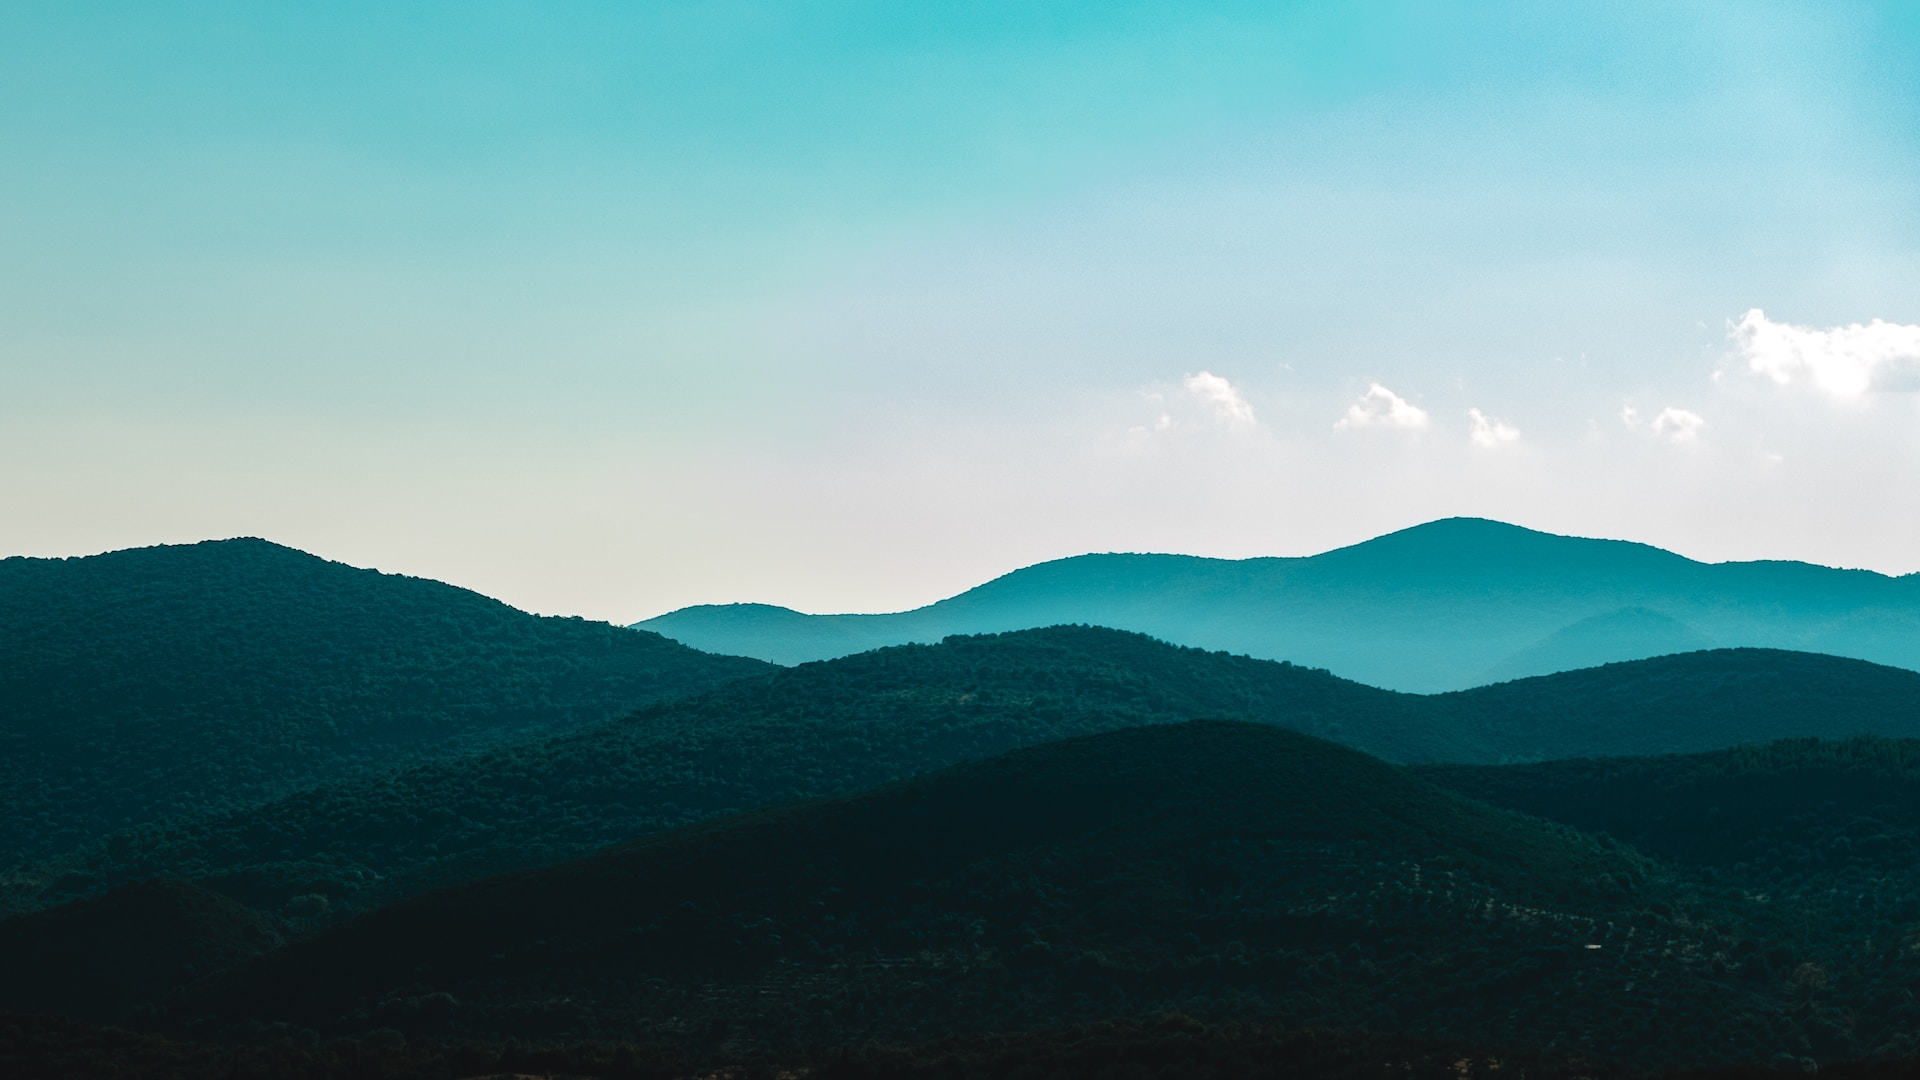
Image conveying a sense of tranquility (<a href="https://unsplash.com/photos/landscape-photography-of-green-mountain-8wz1Q4Q_XAg">photo by Billy Williams on Unsplash</a>).

# Constants

In [10]:
# Hadoop version
HADOOP_VERSION = "3.3.6"
# URL for downloading Hadoop
HADOOP_URL = f"https://dlcdn.apache.org/hadoop/common/hadoop-{HADOOP_VERSION}/hadoop-{HADOOP_VERSION}.tar.gz"

# logging level (should be one of: DEBUG, INFO, WARNING, ERROR, CRITICAL)
LOGGING_LEVEL = "INFO" #@param ["DEBUG", "INFO", "WARNING", "ERROR", "CRITICAL"]


# Imports

In [11]:
import sys
import logging
import subprocess
import os

!pip install Crypto
!pip install pycryptodome
import Crypto

!pip install ssh_utilities
from ssh_utilities import Connection

import shutil
from pathlib import Path
import urllib.request
import tarfile
import xml.etree.ElementTree as ET
import xml.dom.minidom
import glob

# true if running on Google Colab
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
 from google.colab import output

# Setup logging

In [12]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging_level = getattr(logging, LOGGING_LEVEL.upper(), 10)

logging.basicConfig(level=logging_level, \
                    format='%(asctime)s - %(levelname)s: %(message)s', \
                    datefmt='%d-%b-%y %I:%M:%S %p')

logger = logging.getLogger('my_logger')

# Set `JAVA_HOME`

On Google Colab Java is available but we accomodate for the general case of an Ubuntu machine where Java (we pick the `openjdk-19-jre-headless` version) needs to be installed.

In [13]:
# set variable JAVA_HOME (install Java if necessary)
def is_java_installed():
    os.environ['JAVA_HOME'] = os.path.realpath(shutil.which("java")).split('/bin')[0]
    return os.environ['JAVA_HOME']

def install_java():
    # Uncomment and modify the desired version
    # java_version= 'openjdk-11-jre-headless'
    # java_version= 'default-jre'
    # java_version= 'openjdk-17-jre-headless'
    # java_version= 'openjdk-18-jre-headless'
    java_version= 'openjdk-19-jre-headless'

    print(f"Java not found. Installing {java_version} ... (this might take a while)")
    try:
        cmd = f"apt install -y {java_version}"
        subprocess_output = subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        stdout_result = subprocess_output.stdout
        # Process the results as needed
        logger.info("Done installing Java {}".format(java_version))
        os.environ['JAVA_HOME'] = os.path.realpath(shutil.which("java")).split('/bin')[0]
        logger.info("JAVA_HOME is {}".format(os.environ['JAVA_HOME']))
    except subprocess.CalledProcessError as e:
        # Handle the error if the command returns a non-zero exit code
        logger.warn("Command failed with return code {}".format(e.returncode))
        logger.warn("stdout: {}".format(e.stdout))

# Install Java if not available
if is_java_installed():
    logger.info("Java is already installed: {}".format(os.environ['JAVA_HOME']))
else:
    logger.info("Installing Java")
    install_java()

23-Apr-24 05:56:13 PM - INFO: Java is already installed: /usr/lib/jvm/java-11-openjdk-amd64


# Start `sshd` server

The Hadoop cluster needs `ssh` for communication (even if it runs on a single node). See the official documentation: [Setup passphraseless ssh](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/SingleCluster.html#Setup_passphraseless_ssh).

We install `openssh-server` and test if the installation was successful with the shell command

    ssh localhost "echo hi!"

as well as using `Connection` from the Python's `ssh_utilities` library.

## Install `openssh-server`

In [14]:
logger.info("Installing {}".format("openssh-server"))
cmd = ["apt-get", "install", "openssh-server"]
try:
    result = subprocess.check_output(cmd, stderr=subprocess.STDOUT, text=True)
except subprocess.CalledProcessError as e:
    # Access the error message from the output attribute
    error_message = e.output
    print(f"Command failed with error message: {error_message}")

23-Apr-24 05:56:13 PM - INFO: Installing openssh-server


## Configure `sshd` service

In [15]:
if IN_COLAB:
  ssh_config_file = "/etc/ssh/ssh_config"
  with open(ssh_config_file, "r+") as f:
    var = 'StrictHostKeyChecking no'
    line_found = any(line.strip().startswith(var) for line in f)
    if not line_found:
      f.seek(0, os.SEEK_END)
      f.write(var +"\n")

## Start `sshd` service

In [16]:
logger.info("Starting {}".format("openssh-server"))
cmd = ["/etc/init.d/ssh", "restart"]
try:
    result = subprocess.check_output(cmd, stderr=subprocess.STDOUT, text=True)
except subprocess.CalledProcessError as e:
    # Access the error message from the output attribute
    error_message = e.output
    print(f"Command failed with error message: {error_message}")


23-Apr-24 05:56:16 PM - INFO: Starting openssh-server


## Create private/public key

The private/public key pair is needed for passwordless authentication.

Note: for some reason `Crypto` doesn't work without `pycryptodome` (see [ModuleNotFoundError: No module named 'Crypto' Error](https://stackoverflow.com/questions/51824628/modulenotfounderror-no-module-named-crypto-error)).

In [17]:
from Crypto.PublicKey import RSA
key = RSA.generate(2048)
if not os.path.exists(os.path.join(os.path.expanduser('~'), '.ssh')):
  os.makedirs(os.path.join(os.path.expanduser('~'), '.ssh'), mode=700)
#os.chmod(os.path.join(os.path.expanduser('~'),'.ssh'), int('700', base=8))

with open(os.path.join(os.path.expanduser('~'), '.ssh/id_rsa'), 'wb') as f:
  os.chmod(os.path.join(os.path.expanduser('~'),'.ssh/id_rsa'), int('0600', base=8))
  f.write(key.export_key('PEM', passphrase=None))
pubkey = key.publickey()

with open(os.path.join(os.path.expanduser('~'), '.ssh/id_rsa.pub'), 'wb') as f:
    f.write(pubkey.exportKey('OpenSSH'))

In [18]:
with open(os.path.join(os.path.expanduser('~'), '.ssh/authorized_keys'), 'w') as a:
  with open(os.path.join(os.path.expanduser('~'),'.ssh/id_rsa.pub'), 'r') as f:
    a.write(f.read())
  os.chmod(os.path.join(os.path.expanduser('~'), '.ssh/authorized_keys'), int('600', base=8))


## Test `ssh` connection

We are going to test if the passphraseless connection is working by running the command `"echo hi!"` on `localhost` over `ssh`. The output should be `'hi!'` if the `ssh` connection is working.

**1. Test with a shell command**

In [19]:
!ssh localhost "echo hi!"

hi!


**2. Test with Python `ssh_utilities.Connection`**

In [20]:
private_key = os.path.join(os.path.expanduser('~'), '.ssh/id_rsa')
conn = Connection.open('root','localhost', private_key)

try:
    command_output = conn.subprocess.run(['echo', 'hi!'], suppress_out=True, quiet=False,
                          capture_output=True, check=True, cwd=Path('/content'))
except Exception as err:
    logger.error(err)
    print("❌ An exception occurred:")
    print(err)
else:
    logger.info("Successfully executed command on localhost over ssh")
    print("✅ Successfully executed command {} on localhost".format('"ssh localhost \'echo hi!\'"'))
    print("Stdout: {}".format(command_output.stdout.decode("utf-8")))

23-Apr-24 05:56:17 PM - INFO: Connection object will not be thread safe


Will login with private RSA key located in /root/.ssh/id_rsa


23-Apr-24 05:56:17 PM - INFO: Will login with private RSA key located in /root/.ssh/id_rsa


Connecting to server: root@localhost


23-Apr-24 05:56:17 PM - INFO: Connecting to server: root@localhost


When running an executale on server always make sure that full path is specified!!!



23-Apr-24 05:56:17 PM - INFO: When running an executale on server always make sure that full path is specified!!!

23-Apr-24 05:56:17 PM - INFO: could not parse key with Ed25519Key
23-Apr-24 05:56:17 PM - INFO: could not parse key with DSSKey
23-Apr-24 05:56:17 PM - INFO: could not parse key with ECDSAKey
23-Apr-24 05:56:17 PM - INFO: trying to authenticate with private-key
23-Apr-24 05:56:17 PM - INFO: Connected (version 2.0, client OpenSSH_8.9p1)
23-Apr-24 05:56:17 PM - INFO: Authentication (publickey) successful!
23-Apr-24 05:56:17 PM - INFO: successfully authenticated with: private-key


Executing command on remote: echo hi!



23-Apr-24 05:56:17 PM - INFO: Successfully executed command on localhost over ssh


✅ Successfully executed command "ssh localhost 'echo hi!'" on localhost
Stdout: 


# Setup Hadoop


## Download core Hadoop
Download the latest stable version of the core Hadoop distribution from one of the download mirrors locations https://www.apache.org/dyn/closer.cgi/hadoop/common/.

In [21]:
file_name = os.path.basename(HADOOP_URL)
if os.path.isfile(file_name):
   logger.info("{} already exists, not downloading".format(file_name))
else:
  logger.info("Downloading {}".format(file_name))
  urllib.request.urlretrieve(HADOOP_URL, file_name)

23-Apr-24 05:56:17 PM - INFO: Downloading hadoop-3.3.6.tar.gz


## Uncompress archive

In [22]:
dir_name = file_name[:-7]
if os.path.exists(dir_name):
  logger.info("{} is already uncompressed".format(file_name))
else:
  logger.info("Uncompressing {}".format(file_name))
  tar = tarfile.open(file_name)
  tar.extractall()
  tar.close()

23-Apr-24 05:56:49 PM - INFO: Uncompressing hadoop-3.3.6.tar.gz


## Configure Hadoop

In this section we continue following Apache Hadoop's official documentation on how to set up a single node in pseudo-distributed mode (see [Configuration](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/SingleCluster.html#Configuration)).


### Environment variables

In [23]:
os.environ['HADOOP_HOME'] = os.path.join(os.path.join(os.getcwd(), dir_name))
logger.info("HADOOP_HOME is {}".format(os.environ['HADOOP_HOME']))

os.environ['HADOOP_COMMON_HOME'] = os.environ['HADOOP_HOME']
logger.info("HADOOP_COMMON_HOME is {}".format(os.environ['HADOOP_COMMON_HOME']))

os.environ['HADOOP_MAPREDUCE_HOME'] = os.environ['HADOOP_HOME']
logger.info("HADOOP_MAPREDUCE_HOME is {}".format(os.environ['HADOOP_MAPREDUCE_HOME']))

os.environ['HADOOP_YARN_HOME'] = os.environ['HADOOP_HOME']
logger.info("HADOOP_YARN_HOME is {}".format(os.environ['HADOOP_YARN_HOME']))

os.environ['PATH'] = ':'.join([os.path.join(os.environ['HADOOP_HOME'], 'bin'), os.environ['PATH']])
logger.info("PATH is {}".format(os.environ['PATH']))

os.environ['HADOOP_VERSION'] = HADOOP_VERSION
logger.info("HADOOP_VERSION is {}".format(os.environ['HADOOP_VERSION']))

23-Apr-24 05:57:23 PM - INFO: HADOOP_HOME is /content/hadoop-3.3.6
23-Apr-24 05:57:23 PM - INFO: HADOOP_COMMON_HOME is /content/hadoop-3.3.6
23-Apr-24 05:57:23 PM - INFO: HADOOP_MAPREDUCE_HOME is /content/hadoop-3.3.6
23-Apr-24 05:57:23 PM - INFO: HADOOP_YARN_HOME is /content/hadoop-3.3.6
23-Apr-24 05:57:23 PM - INFO: PATH is /content/hadoop-3.3.6/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
23-Apr-24 05:57:23 PM - INFO: HADOOP_VERSION is 3.3.6


### Hadoop configuration files

Throughout this notebook we're going to edit four important Hadoop configuration files:


*   `core-site.xml` containing the *site-specific configuration* of the Hadoop core
*   `hdfs-site.xml` containing the *site-specific configuration* of Hadoop's HDFS
*   `yarn-site.xml` containing the *site-specific configuration* of Hadoop's YARN
*   `mapred-site.xml` containing the *site-specific configuration* of Hadoop's MapReduce

Additionally, we are going to edit the file `hadoop-env.sh`, a helper file containing environment variables needed by the shell scripts used to start the cluster.

All these files can be found in `etc/hadoop` under `$HADOOP_HOME` (the Hadoop installation folder).

In [24]:
# site-specific configuration files
core_site_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/core-site.xml')
hdfs_site_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/hdfs-site.xml')
yarn_site_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/yarn-site.xml')
mapred_site_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/mapred-site.xml')

# Hadoop environment variables
hadoop_env_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/hadoop-env.sh')

In [25]:
!ls $HADOOP_HOME/etc/hadoop/*xml $HADOOP_HOME/etc/hadoop/hadoop-env.sh

/content/hadoop-3.3.6/etc/hadoop/capacity-scheduler.xml
/content/hadoop-3.3.6/etc/hadoop/core-site.xml
/content/hadoop-3.3.6/etc/hadoop/hadoop-env.sh
/content/hadoop-3.3.6/etc/hadoop/hadoop-policy.xml
/content/hadoop-3.3.6/etc/hadoop/hdfs-rbf-site.xml
/content/hadoop-3.3.6/etc/hadoop/hdfs-site.xml
/content/hadoop-3.3.6/etc/hadoop/httpfs-site.xml
/content/hadoop-3.3.6/etc/hadoop/kms-acls.xml
/content/hadoop-3.3.6/etc/hadoop/kms-site.xml
/content/hadoop-3.3.6/etc/hadoop/mapred-site.xml
/content/hadoop-3.3.6/etc/hadoop/yarn-site.xml


### Functions for editing Hadoop configuration files

In order to edit the site-specific configuration files in an orderly fashion, we have created the functions:

*   `clear_conf_file(file)` to remove all properties from the XML file `file`
*   `edit_conf_file(file, propertyname, propertyvalue)` to add property name and value in the proper format to the XML file `file`
*   `print_conf_file(file)` to pretty-print the XML file `file`

In [26]:
def clear_conf_file(file):
  tree = ET.parse(file)
  root = tree.getroot()
  # remove all properties
  for el in list(root):
     root.remove(el)
  tree.write(file, encoding='utf-8', xml_declaration=True)
  # pretty-print
  dom = xml.dom.minidom.parse(file)

def edit_conf_file(file, propertyname, propertyvalue):
  tree = ET.parse(file)
  root = tree.getroot()
  logger.info("add property {} to {}".format(propertyname, file))
  property = ET.SubElement(root, 'property')
  name = ET.SubElement(property, 'name')
  name.text = propertyname
  value = ET.SubElement(property, 'value')
  value.text = propertyvalue
  tree.write(file, encoding='utf-8', xml_declaration=True)

def print_conf_file(file):
  # pretty-print
  dom = xml.dom.minidom.parse(file)
  print(dom.toprettyxml())

### Edit `core-site.xml` and `hdfs-site.xml`

Let us configure two properties:

*   `fs.defaultFS` (the URI of the default file system) to `hdfs://localhost:9000` in `core-site.xml`
*   `dfs.replication` to $1$ (the default is $3$) in `hdfs-site.xml`

In [27]:
clear_conf_file(core_site_file)
edit_conf_file(core_site_file, 'fs.defaultFS', 'hdfs://localhost:9000')
print_conf_file(core_site_file)

23-Apr-24 05:57:23 PM - INFO: add property fs.defaultFS to /content/hadoop-3.3.6/etc/hadoop/core-site.xml


<?xml version="1.0" ?>
<configuration>
	

	<property>
		<name>fs.defaultFS</name>
		<value>hdfs://localhost:9000</value>
	</property>
</configuration>



In [28]:
clear_conf_file(hdfs_site_file)
edit_conf_file(hdfs_site_file, 'dfs.replication', '1')
print_conf_file(hdfs_site_file)

23-Apr-24 05:57:23 PM - INFO: add property dfs.replication to /content/hadoop-3.3.6/etc/hadoop/hdfs-site.xml


<?xml version="1.0" ?>
<configuration>
	


	<property>
		<name>dfs.replication</name>
		<value>1</value>
	</property>
</configuration>



### Edit `hadoop-env.sh`

In [29]:
users = ['HDFS_NAMENODE_USER', \
         'HDFS_DATANODE_USER', \
         'HDFS_SECONDARYNAMENODE_USER', \
         'YARN_RESOURCEMANAGER_USER', \
         'YARN_NODEMANAGER_USER', \
         'YARN_PROXYSERVER_USER']

logger.info("Editing {}".format(hadoop_env_file))

with open(hadoop_env_file, "r+") as f:
  for u in users:
    var = 'export ' + u + '=root'
    line_found = any(line.startswith(var) for line in f)
    if not line_found:
      f.seek(0, os.SEEK_END)
      f.write(var +"\n")
  line_found = any(line.startswith('export JAVA_HOME=') for line in f)
  if not line_found:
      f.seek(0, os.SEEK_END)
      f.write('export JAVA_HOME='+os.environ['JAVA_HOME']+"\n")

23-Apr-24 05:57:23 PM - INFO: Editing /content/hadoop-3.3.6/etc/hadoop/hadoop-env.sh


### Hadoop's default values for configuration files


By providing site-specific configuration files one can override any of the default properties. The default values files corresponfing to the site-specific files are:

*  `core-default.xml`
*  `hdfs-default.xml`
*  `yarn-default.xml`
*  `mapred-default.xml`

These are read-only files that contain all default values for Hadoop properties (see [cluster setup](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/ClusterSetup.html#Configuring_Hadoop_in_Non-Secure_Mode)) and can be viewed at:


In [30]:
list(glob.iglob(os.environ['HADOOP_HOME']+ '/**/*default.xml', recursive=True))

['/content/hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-common/core-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-hdfs-rbf/hdfs-rbf-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-yarn/hadoop-yarn-common/yarn-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-mapreduce-client/hadoop-mapreduce-client-core/mapred-default.xml']

In [31]:
print('\n'.join([core_site_file, hdfs_site_file, yarn_site_file, mapred_site_file]))

/content/hadoop-3.3.6/etc/hadoop/core-site.xml
/content/hadoop-3.3.6/etc/hadoop/hdfs-site.xml
/content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
/content/hadoop-3.3.6/etc/hadoop/mapred-site.xml


## Initialize the namenode

In [32]:
logger.info("Formatting NameNode")
cmd = ["hdfs", "namenode", "-format", "-nonInteractive"]
result = subprocess.call(cmd, stderr=subprocess.STDOUT)

23-Apr-24 05:57:24 PM - INFO: Formatting NameNode


# Start HDFS

Launch a single-node HDFS cluster with the command `start-dfs.sh`.

In [33]:
subprocess_output = subprocess.run([os.path.join(os.environ['HADOOP_HOME'], 'sbin', 'start-dfs.sh')], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

Starting namenodes on [localhost]
Starting datanodes
Starting secondary namenodes [ac1d0ad57915]
ac1d0ad57915: Warning: Permanently added 'ac1d0ad57915' (ED25519) to the list of known hosts.



In [34]:
!/content/hadoop-3.3.6/sbin/stop-dfs.sh
!/content/hadoop-3.3.6/sbin/start-dfs.sh

Stopping namenodes on [localhost]
Stopping datanodes
Stopping secondary namenodes [ac1d0ad57915]
Starting namenodes on [localhost]
Starting datanodes
Starting secondary namenodes [ac1d0ad57915]


# HDFS processes and ports

We have started some Java virtual machines corresponding to different Hadoop services. By using `lsof` to show listening ports you should get something like this:
```
COMMAND   PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
java    13177 root  341u  IPv4 357089      0t0  TCP *:9870 (LISTEN)
java    13177 root  349u  IPv4 358597      0t0  TCP 127.0.0.1:9000 (LISTEN)
java    13297 root  342u  IPv4 359615      0t0  TCP *:9866 (LISTEN)
java    13297 root  345u  IPv4 358674      0t0  TCP 127.0.0.1:40349 (LISTEN)
java    13297 root  374u  IPv4 358786      0t0  TCP *:9864 (LISTEN)
java    13297 root  375u  IPv4 358790      0t0  TCP *:9867 (LISTEN)
java    13515 root  343u  IPv4 360840      0t0  TCP *:9868 (LISTEN)
```

In [35]:
!lsof -n -i -P +c0 -sTCP:LISTEN -ac java

COMMAND   PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
java    28394 root  341u  IPv4 715987      0t0  TCP *:9870 (LISTEN)
java    28394 root  349u  IPv4 718872      0t0  TCP 127.0.0.1:9000 (LISTEN)
java    28510 root  342u  IPv4 718985      0t0  TCP *:9866 (LISTEN)
java    28510 root  345u  IPv4 718624      0t0  TCP 127.0.0.1:33375 (LISTEN)
java    28510 root  374u  IPv4 719038      0t0  TCP *:9864 (LISTEN)
java    28510 root  375u  IPv4 719108      0t0  TCP *:9867 (LISTEN)
java    28705 root  343u  IPv4 721716      0t0  TCP *:9868 (LISTEN)


As you can see, we have multiple services running on different ports all spawned by different Java processes corresponding to:


*   NameNode
*   DataNode
*   Secondary NameNode




port number | description | configured in
--- | --- | --- |
9870 | dfs.namenode.http-address | [hdfs-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml) |
9000 | fs.defaultFS | as defined in `core-site.xml` |
9864 | dfs.datanode.http.address | [hdfs-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml) |
9866 | dfs.datanode.address| [hdfs-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml) |
9867 | dfs.datanode.ipc.address | [hdfs-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml) |
9868 | dfs.namenode.secondary.http-address | [hdfs-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml) |


## Check if HDFS is up and running

Once HDFS is up and running there should be a total of $7$ `java` listening ports and six of them are precisely ports $9870$, $9000$, $9864$, $9866$, $9876$, $9868$.

Let us check if this is the case introducing a cycle of 20 retries (one per second) to check if all the required ports are available. This check is needed for non-interactive runs of the notebook.

In [36]:
%%bash
counter=0
until [ $counter -gt 20 ]
do
  ((counter++))
  sleep 1
  # counting lines, exclude header and jupyter port 9000
  if [ $(lsof -n -i -P +c0 -sTCP:LISTEN -ac java| wc -l ) -ge 8 ] && \
  [ $(lsof -n -aiTCP:9870 -aiTCP:9000 -aiTCP:9864 -aiTCP:9866 -aiTCP:9867 -aiTCP:9868 -P +c0 -sTCP:LISTEN -ac java | wc -l) -eq 7 ]
  then
   echo "HDFS is up and running"
   echo "Time to start: $counter secs"
   exit
  fi
done
echo "Some HDFS ports are missing. Wait some more or restart HDFS."

HDFS is up and running
Time to start: 1 secs


## `lsof` for viewing listening ports

`lsof` is an exceptionally valuable command. With the option `-i` it can be used to show processes listening to network connections.

An example: check for `java` listening to a specific port ($9864$)

In [37]:
!lsof -iTCP:9864 -n -P +c0 -sTCP:LISTEN -ac java

COMMAND   PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
java    28510 root  374u  IPv4 719038      0t0  TCP *:9864 (LISTEN)


### Options used in `lsof`:

* `-i` specifies that you want to display only network files, that is open network connections
* `-n` and `-P` tell `lsof` to show ports and IP addresses in numeric form
* the option `+c0` is used to show a longer substring of the name of the UNIX command associated with the process (https://linux.die.net/man/8/lsof)
* `-sTCP:LISTEN` filters for TCP connections in state `LISTEN`



# Check the NameNode

## On the command-line

Run the command `hdfs dfsadmin -report`.

In [38]:
subprocess_output = subprocess.run([os.path.join(os.environ['HADOOP_HOME'], 'bin', 'hdfs'), 'dfsadmin', '-report'], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

Configured Capacity: 115658190848 (107.72 GB)
Present Capacity: 85302824960 (79.44 GB)
DFS Remaining: 85302800384 (79.44 GB)
DFS Used: 24576 (24 KB)
DFS Used%: 0.00%
Replicated Blocks:
	Under replicated blocks: 0
	Blocks with corrupt replicas: 0
	Missing blocks: 0
	Missing blocks (with replication factor 1): 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0
Erasure Coded Block Groups: 
	Low redundancy block groups: 0
	Block groups with corrupt internal blocks: 0
	Missing block groups: 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (1):

Name: 127.0.0.1:9866 (localhost)
Hostname: ac1d0ad57915
Decommission Status : Normal
Configured Capacity: 115658190848 (107.72 GB)
DFS Used: 24576 (24 KB)
Non DFS Used: 30338588672 (28.26 GB)
DFS Remaining: 85302800384 (79.44 GB)
DFS Used%: 0.00%
DFS Remaining%: 73.75%
Configured Cache Capacity: 0 (0 B)
Cache

## In the Web UI

The namenode runs a Web interface displaying information about the current status of the cluster (see [HdfsUserGuide.html#Web_Interface](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-hdfs/HdfsUserGuide.html#Web_Interface)). By default, the dfs namenode web ui will listen on port $9870$.

Let us open the Web UI in another tab in the browser with Google Colab's `output` library (source: https://github.com/googlecolab/colabtools/tree/main/google/colab/output, documentation: [Browsing to servers executing on the kernel](https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=95mvP1VeYETf)).

### Serve the NameNode Web UI

In [39]:
!wget localhost:9870

--2024-04-23 17:58:42--  http://localhost:9870/
Resolving localhost (localhost)... 127.0.0.1, ::1
Connecting to localhost (localhost)|127.0.0.1|:9870... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://localhost:9870/index.html [following]
--2024-04-23 17:58:43--  http://localhost:9870/index.html
Reusing existing connection to localhost:9870.
HTTP request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [text/html]
Saving to: ‘index.html’

index.html          100%[===================>]   1.05K  --.-KB/s    in 0s      

2024-04-23 17:58:43 (110 MB/s) - ‘index.html’ saved [1079/1079]



In [40]:
%%capture namenode_url
if IN_COLAB:
  port = 9870
  output.serve_kernel_port_as_window(port, path='/index.html')

In [41]:
if IN_COLAB:
  namenode_url.show()

<IPython.core.display.Javascript object>

This is what you should see if you open the above link in a newly opened tab or window in your browser
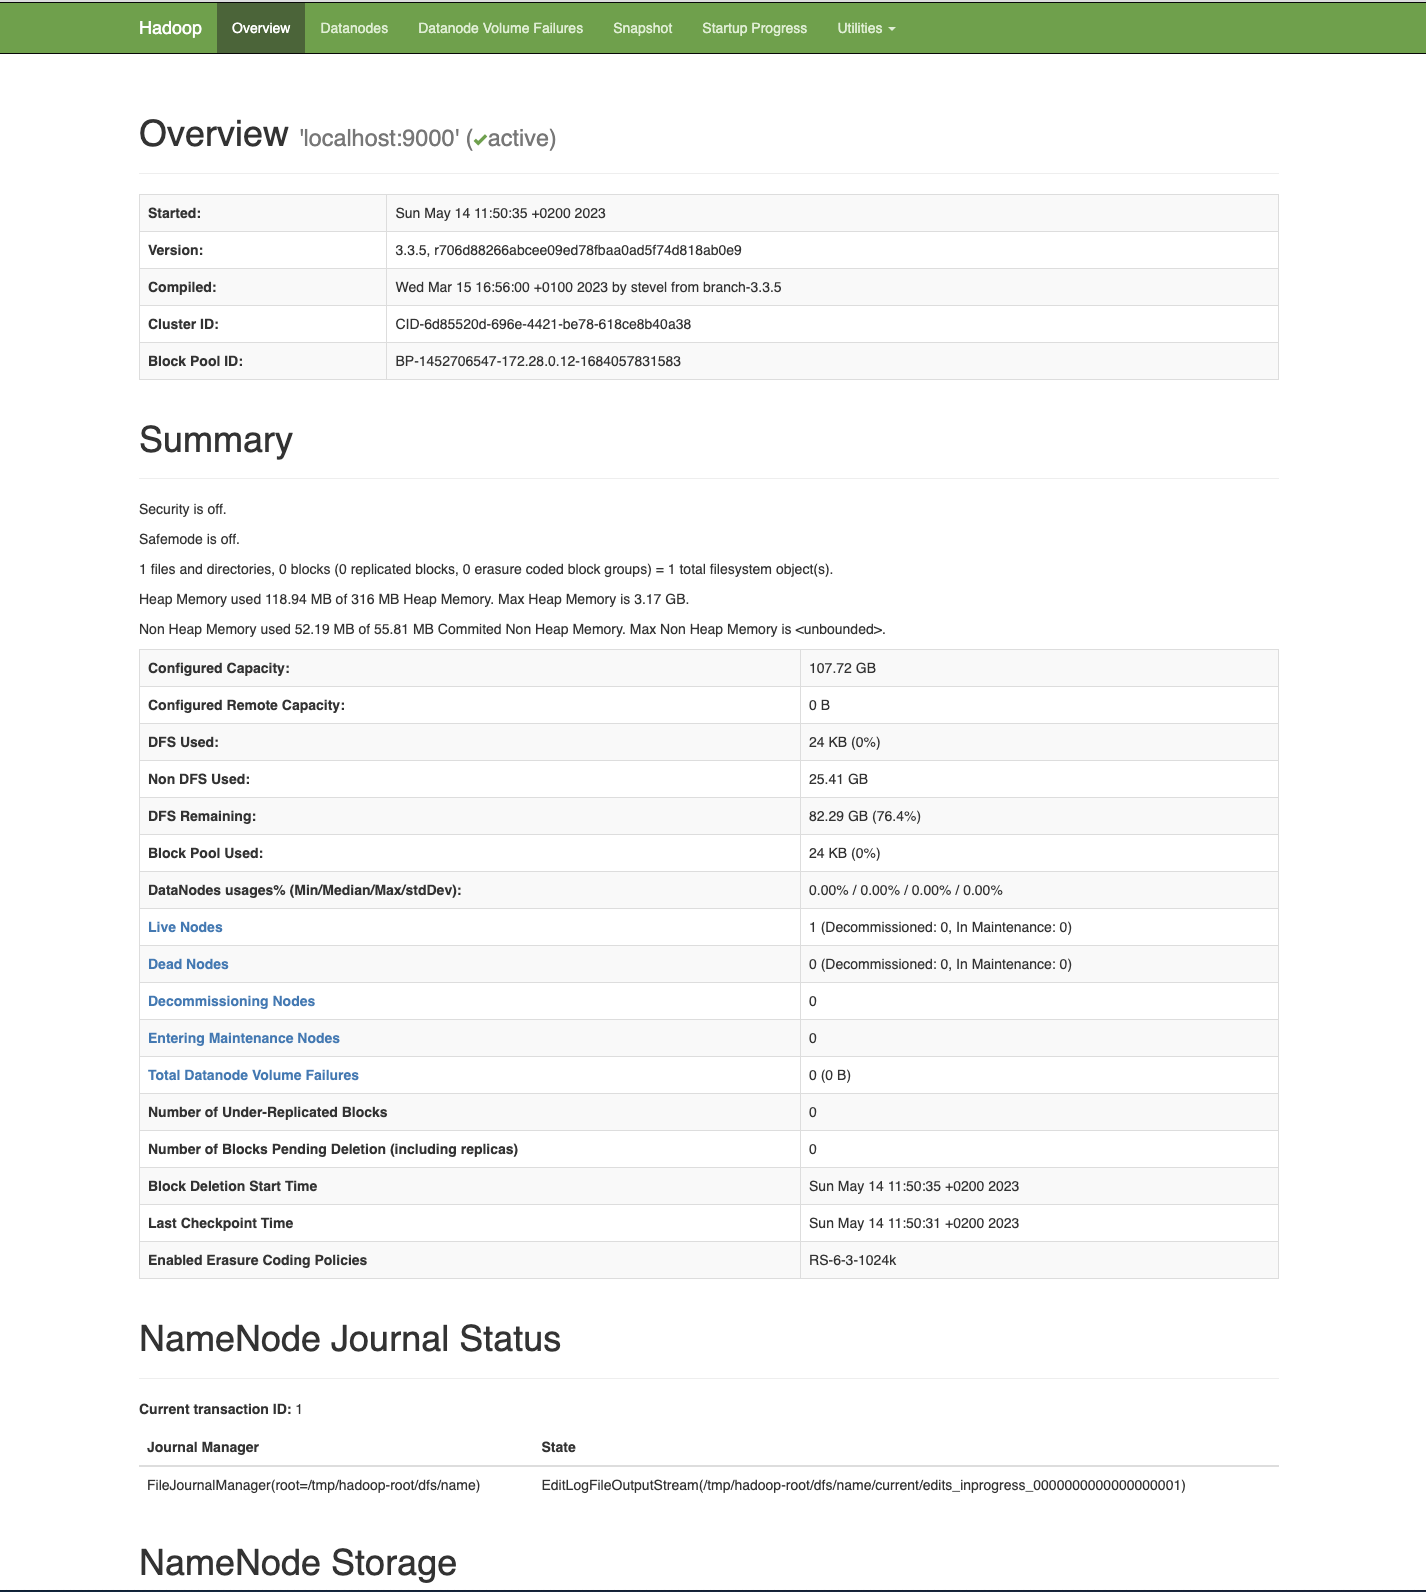

On port $9864$ you can reach the datanode.

In [42]:
%%capture datanode_url
if IN_COLAB:
  port = 9864
  output.serve_kernel_port_as_window(port, path='/index.html')

In [43]:
if IN_COLAB:
  datanode_url.show()

<IPython.core.display.Javascript object>

### A note on Google Colaboratory advanced outputs

Throughout this notebook, I use the function `output.serve_kernel_port_as_window` to serve Web pages from Google Colab.

You can find the documentation for Google Colab's advanced outputs library at: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=Browsing_to_servers_executing_on_the_kernel.

Before serving a link, I always use `wget` to see if there are any redirections that need to be included in the `path` option. For instance:

    output.serve_kernel_port_as_window(9870, path='/index.html')

works but

    output.serve_kernel_port_as_window(9870)

will not work!

Oddly, the function `output.serve_kernel_port_as_window` is deprecated in favor of `serve_kernel_port_as_iframe`, which does not work.

In [44]:
if IN_COLAB:
  help(output.serve_kernel_port_as_window)

Help on function serve_kernel_port_as_window in module google.colab.output._util:

serve_kernel_port_as_window(port, path='/', anchor_text=None)
    Displays a link in the output to open a browser tab to a port on the kernel.
    
    DEPRECATED; Browser security updates have broken this feature. Use
    `serve_kernel_port_as_iframe` instead. See
    https://developer.chrome.com/en/docs/privacy-sandbox/storage-partitioning/.
    
    
    This allows viewing URLs hosted on the kernel in new browser tabs.
    
    The URL will only be valid for the current user while the notebook is open in
    Colab.
    
    Args:
      port: The kernel port to be exposed to the client.
      path: The path to be navigated to.
      anchor_text: Text content of the anchor link.



# Test HDFS

Upload the Hadoop distribution `.tar.gz` file (this is just a "big" file that's already there) to the HDFS filesystem using the command

    hdfs dfs -put <filename>

Check DFS usage before:

In [45]:
!hdfs dfsadmin -report | grep "^DFS Used" | tail -2

DFS Used: 24576 (24 KB)
DFS Used%: 0.00%


In [46]:
!echo $(basename $HADOOP_URL)
# create home directory on HDFS
!hdfs dfs -mkdir -p /user/root
# upload file to HDFS
!hdfs dfs -put $(basename $HADOOP_URL)
# list HDFS home
!hdfs dfs -ls -h

hadoop-3.3.6.tar.gz
Found 1 items
-rw-r--r--   1 root supergroup    696.3 M 2024-04-23 17:59 hadoop-3.3.6.tar.gz


You should now see that the value for DFS Used has increased from $0.0\%$ to a value $>0.0\%$.

In [47]:
!hdfs dfsadmin -report | grep "^DFS Used" | tail -2

DFS Used: 735836062 (701.75 MB)
DFS Used%: 0.64%


The same is shown in the Web UI (you might have to refresh the page).

| | |
| -: | -: |
| **Configured Capacity:**	| 107.72 GB |
| **Configured Remote Capacity:** | 	0 B |
| **DFS Used:** |	701.76 MB (0.64%) |




(see https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/SingleCluster.html#YARN_on_a_Single_Node)

Clean up.

In [48]:
!hdfs dfs -rm -r $(basename $HADOOP_URL)
!hdfs dfs -ls

Deleted hadoop-3.3.6.tar.gz


# Run a MapReduce job in local mode

If you run a MapReduce job at this point (without starting YARN), the job will run locally.

We are resetting the YARN and MapReduce configuration files to their initial empty state in case you are not running the notebook for the first time.

In [49]:
clear_conf_file(yarn_site_file)
clear_conf_file(mapred_site_file)

## How to find MapReduce examples

The Hadoop distribution comes with several examples (both sources and compiled). Here we are going to show how to find the runnable JAR files.

Search for MapReduce examples with `find`. The MapReduce examples JAR is named

```
hadoop-mapreduce-examples-${HADOOP_VERSION}.jar
```

In [50]:
!find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar"

/content/hadoop-3.3.6/share/hadoop/mapreduce/hadoop-mapreduce-examples-3.3.6.jar


Call the JAR file to get a list of all available MapReduce examples.

In [51]:
!hadoop jar $(find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar")

An example program must be given as the first argument.
Valid program names are:
  aggregatewordcount: An Aggregate based map/reduce program that counts the words in the input files.
  aggregatewordhist: An Aggregate based map/reduce program that computes the histogram of the words in the input files.
  bbp: A map/reduce program that uses Bailey-Borwein-Plouffe to compute exact digits of Pi.
  dbcount: An example job that count the pageview counts from a database.
  distbbp: A map/reduce program that uses a BBP-type formula to compute exact bits of Pi.
  grep: A map/reduce program that counts the matches of a regex in the input.
  join: A job that effects a join over sorted, equally partitioned datasets
  multifilewc: A job that counts words from several files.
  pentomino: A map/reduce tile laying program to find solutions to pentomino problems.
  pi: A map/reduce program that estimates Pi using a quasi-Monte Carlo method.
  randomtextwriter: A map/reduce program that writes 10GB of r

Run the `pi` example without arguments to get a usage message.

In [52]:
!hadoop jar $(find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar") pi

Usage: org.apache.hadoop.examples.QuasiMonteCarlo <nMaps> <nSamples>
Generic options supported are:
-conf <configuration file>        specify an application configuration file
-D <property=value>               define a value for a given property
-fs <file:///|hdfs://namenode:port> specify default filesystem URL to use, overrides 'fs.defaultFS' property from configurations.
-jt <local|resourcemanager:port>  specify a ResourceManager
-files <file1,...>                specify a comma-separated list of files to be copied to the map reduce cluster
-libjars <jar1,...>               specify a comma-separated list of jar files to be included in the classpath
-archives <archive1,...>          specify a comma-separated list of archives to be unarchived on the compute machines

The general command line syntax is:
command [genericOptions] [commandOptions]



## Run the `pi` MapReduce app

Run the `pi` example with


*   `<nMaps>` $=2$  
*   `<nSamples>` $= 100$



In [53]:
!yarn jar $(find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar") pi 2 100

Number of Maps  = 2
Samples per Map = 100
Wrote input for Map #0
Wrote input for Map #1
Starting Job
2024-04-23 17:59:32,455 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2024-04-23 17:59:32,660 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2024-04-23 17:59:32,660 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2024-04-23 17:59:33,024 INFO input.FileInputFormat: Total input files to process : 2
2024-04-23 17:59:33,046 INFO mapreduce.JobSubmitter: number of splits:2
2024-04-23 17:59:33,437 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local744529872_0001
2024-04-23 17:59:33,437 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-04-23 17:59:33,665 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
2024-04-23 17:59:33,666 INFO mapreduce.Job: Running job: job_local744529872_0001
2024-04-23 17:59:33,671 INFO mapred.LocalJobRunner: OutputCommitter set in config null
2024-04-2

# Start YARN

The script that we are going to use to start YARN is

    $HADOOP_HOME/sbin/start-yarn.sh

Before launching YARN, ensure proper configuration in both `yarn-site.xml` and `mapred-site.xml`. For YARN, it is essential to configure the `yarn.resourcemanager.hostname` as once this is set, many other services addresses depend on its value `${yarn.resourcemanager.hostname}` and do not need to be configured one by one.

In `mapred-site.xml` we want to configure MapReduce to submitting jobs to the YARN queue by default.

We just configured the minimal set of properties needed to run an example for this tutorial. In general, you might want to customize these XML configuration files to align with your system requirements and specifications.

Some useful links for configuring YARN:

*   https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/SingleCluster.html#YARN_on_a_Single_Node
* https://hadoop.apache.org/docs/stable/hadoop-yarn/hadoop-yarn-common/yarn-default.xml
*   https://hadoop.apache.org/docs/current/hadoop-yarn/hadoop-yarn-site/WebApplicationProxy.html



## Configure `yarn-site.xml`

In [54]:
clear_conf_file(yarn_site_file)
edit_conf_file(yarn_site_file, 'yarn.resourcemanager.hostname', 'localhost')
# Shuffle service that needs to be set for Map Reduce applications.
edit_conf_file(yarn_site_file, 'yarn.nodemanager.aux-services', 'mapreduce_shuffle')
# Configuration to enable or disable log aggregation (default is false)
edit_conf_file(yarn_site_file, 'yarn.log-aggregation-enable', 'true')
# Environment properties to be inherited by containers from NodeManagers
edit_conf_file(yarn_site_file, 'yarn.nodemanager.env-whitelist', 'JAVA_HOME,HADOOP_COMMON_HOME,HADOOP_HDFS_HOME,HADOOP_CONF_DIR,CLASSPATH_PREPEND_DISTCACHE,HADOOP_YARN_HOME,HADOOP_HOME,PATH,LANG,TZ,HADOOP_MAPRED_HOME')
# Web proxy address
edit_conf_file(yarn_site_file, 'yarn.web-proxy.address', '127.0.0.1:3141')
# NM Webapp address
#edit_conf_file(yarn_site_file, 'yarn.nodemanager.hostname', 'localhost:8042')
# Configurations for History Server
edit_conf_file(yarn_site_file, 'yarn.log-aggregation.retain-seconds', '600')
edit_conf_file(yarn_site_file, 'yarn.log-aggregation.retain-check-interval-seconds', '60')
print_conf_file(yarn_site_file)

23-Apr-24 05:59:36 PM - INFO: add property yarn.resourcemanager.hostname to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
23-Apr-24 05:59:36 PM - INFO: add property yarn.nodemanager.aux-services to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
23-Apr-24 05:59:36 PM - INFO: add property yarn.log-aggregation-enable to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
23-Apr-24 05:59:36 PM - INFO: add property yarn.nodemanager.env-whitelist to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
23-Apr-24 05:59:36 PM - INFO: add property yarn.web-proxy.address to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
23-Apr-24 05:59:36 PM - INFO: add property yarn.log-aggregation.retain-seconds to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
23-Apr-24 05:59:36 PM - INFO: add property yarn.log-aggregation.retain-check-interval-seconds to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml


<?xml version="1.0" ?>
<configuration>
	




	<property>
		<name>yarn.resourcemanager.hostname</name>
		<value>localhost</value>
	</property>
	<property>
		<name>yarn.nodemanager.aux-services</name>
		<value>mapreduce_shuffle</value>
	</property>
	<property>
		<name>yarn.log-aggregation-enable</name>
		<value>true</value>
	</property>
	<property>
		<name>yarn.nodemanager.env-whitelist</name>
		<value>JAVA_HOME,HADOOP_COMMON_HOME,HADOOP_HDFS_HOME,HADOOP_CONF_DIR,CLASSPATH_PREPEND_DISTCACHE,HADOOP_YARN_HOME,HADOOP_HOME,PATH,LANG,TZ,HADOOP_MAPRED_HOME</value>
	</property>
	<property>
		<name>yarn.web-proxy.address</name>
		<value>127.0.0.1:3141</value>
	</property>
	<property>
		<name>yarn.log-aggregation.retain-seconds</name>
		<value>600</value>
	</property>
	<property>
		<name>yarn.log-aggregation.retain-check-interval-seconds</name>
		<value>60</value>
	</property>
</configuration>



### Some explanations

**`yarn.web-proxy.address`** is needed so that `start-yarn.sh` also launches the Web proxy (needed for navigating the different Web services). Here is the relevant code from `start-yarn.sh`:

```
# start proxyserver
PROXYSERVER=$("${HADOOP_HDFS_HOME}/bin/hdfs" getconf -confKey  yarn.web-proxy.address 2>&- | cut -f1 -d:)
if [[ -n ${PROXYSERVER} ]]; then
 hadoop_uservar_su yarn proxyserver "${HADOOP_YARN_HOME}/bin/yarn" \
      --config "${HADOOP_CONF_DIR}" \
      --workers \
      --hostnames "${PROXYSERVER}" \
      --daemon start \
      proxyserver
 (( HADOOP_JUMBO_RETCOUNTER=HADOOP_JUMBO_RETCOUNTER + $? ))
fi
```
We just picked an arbitrary port `3141`.

To check if `yarn.web-proxy.address` use:

    hdfs getconf -confKey  yarn.web-proxy.address

In [55]:
!hdfs getconf -confKey  yarn.web-proxy.address

127.0.0.1:3141


**`yarn.log-aggregation-enable`** needs to be set to `true` (by default it is `false`) in order to be able to view the logs of the application after it's completed using the command

    yarn logs -applicationId <app ID>
    
When log aggregation is enabled, log files are collated from local containers to a central location (see [Running on YARN/Debugging your application](https://spark.apache.org/docs/3.5.0/running-on-yarn.html#debugging-your-application)).

**`yarn.log-aggregation.retain-seconds`** determines how long to keep aggregation logs before deleting them. I configured 10 minutes for this tutorial.

**`yarn.log-aggregation.retain-check-interval-seconds`** from [yarn-default.xml](https://hadoop.apache.org/docs/stable/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) How long to wait between aggregated log retention checks. If set to 0 or a negative value then the value is computed as one-tenth of the aggregated log retention time. Be careful set this too small and you will spam the name node.

## Configure `mapred-site.xml`

We want to run MapReduce jobs on YARN by default (property `mapreduce.framework.name`) and we want to configure the address for the JobHistory daemon.

In [56]:
clear_conf_file(mapred_site_file)
edit_conf_file(mapred_site_file, 'mapreduce.framework.name', 'yarn')
# Shuffle service that needs to be set for Map Reduce applications.
edit_conf_file(mapred_site_file, 'mapreduce.application.classpath',
               os.environ['HADOOP_HOME'] + '/share/hadoop/mapreduce/*:' +
               os.environ['HADOOP_HOME']+ '/share/hadoop/mapreduce/lib/*')
# this should also work (with the variable ${HADOOP_HOME})
# edit_conf_file(mapred_site_file, 'mapreduce.application.classpath',
#               '${HADOOP_HOME}/share/hadoop/mapreduce/*:' +
#               '${HADOOP_HOME}/share/hadoop/mapreduce/lib/*')
# Configurations for History Server
edit_conf_file(mapred_site_file, 'mapreduce.jobhistory.address', 'localhost:10020')
edit_conf_file(mapred_site_file, 'mapreduce.jobhistory.webapp.address', 'localhost:19888')
print_conf_file(mapred_site_file)

23-Apr-24 05:59:38 PM - INFO: add property mapreduce.framework.name to /content/hadoop-3.3.6/etc/hadoop/mapred-site.xml
23-Apr-24 05:59:38 PM - INFO: add property mapreduce.application.classpath to /content/hadoop-3.3.6/etc/hadoop/mapred-site.xml
23-Apr-24 05:59:38 PM - INFO: add property mapreduce.jobhistory.address to /content/hadoop-3.3.6/etc/hadoop/mapred-site.xml
23-Apr-24 05:59:38 PM - INFO: add property mapreduce.jobhistory.webapp.address to /content/hadoop-3.3.6/etc/hadoop/mapred-site.xml


<?xml version="1.0" ?>
<configuration>
	


	<property>
		<name>mapreduce.framework.name</name>
		<value>yarn</value>
	</property>
	<property>
		<name>mapreduce.application.classpath</name>
		<value>/content/hadoop-3.3.6/share/hadoop/mapreduce/*:/content/hadoop-3.3.6/share/hadoop/mapreduce/lib/*</value>
	</property>
	<property>
		<name>mapreduce.jobhistory.address</name>
		<value>localhost:10020</value>
	</property>
	<property>
		<name>mapreduce.jobhistory.webapp.address</name>
		<value>localhost:19888</value>
	</property>
</configuration>



## Launch YARN

In [57]:
!$HADOOP_HOME/sbin/stop-yarn.sh
!$HADOOP_HOME/sbin/start-yarn.sh

Stopping nodemanagers
Stopping resourcemanager
Stopping proxy server [127.0.0.1]
127.0.0.1: Warning: Permanently added '127.0.0.1' (ED25519) to the list of known hosts.
Starting resourcemanager
Starting nodemanagers


In [58]:
!lsof -n -i -P +c0 -sTCP:LISTEN -ac java

COMMAND   PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
java    28394 root  341u  IPv4 715987      0t0  TCP *:9870 (LISTEN)
java    28394 root  349u  IPv4 718872      0t0  TCP 127.0.0.1:9000 (LISTEN)
java    28510 root  342u  IPv4 718985      0t0  TCP *:9866 (LISTEN)
java    28510 root  345u  IPv4 718624      0t0  TCP 127.0.0.1:33375 (LISTEN)
java    28510 root  374u  IPv4 719038      0t0  TCP *:9864 (LISTEN)
java    28510 root  375u  IPv4 719108      0t0  TCP *:9867 (LISTEN)
java    28705 root  343u  IPv4 721716      0t0  TCP *:9868 (LISTEN)
java    30215 root  366u  IPv4 743524      0t0  TCP 127.0.0.1:8088 (LISTEN)
java    30328 root  382u  IPv4 745359      0t0  TCP *:43895 (LISTEN)
java    30328 root  393u  IPv4 746504      0t0  TCP *:8040 (LISTEN)
java    30328 root  403u  IPv4 746519      0t0  TCP *:13562 (LISTEN)


We now have some new `java` processes that have been added to the list of listening ports (you might need to wait and refresh the previous cell to see them all):
```
COMMAND   PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
java    13177 root  341u  IPv4 357089      0t0  TCP *:9870 (LISTEN)
java    13177 root  349u  IPv4 358597      0t0  TCP 127.0.0.1:9000 (LISTEN)
java    13297 root  342u  IPv4 359615      0t0  TCP *:9866 (LISTEN)
java    13297 root  345u  IPv4 358674      0t0  TCP 127.0.0.1:40349 (LISTEN)
java    13297 root  374u  IPv4 358786      0t0  TCP *:9864 (LISTEN)
java    13297 root  375u  IPv4 358790      0t0  TCP *:9867 (LISTEN)
java    13515 root  343u  IPv4 360840      0t0  TCP *:9868 (LISTEN)
java    27447 root  366u  IPv4 756489      0t0  TCP 127.0.0.1:8088 (LISTEN)
java    27447 root  373u  IPv4 759769      0t0  TCP 127.0.0.1:8033 (LISTEN)
java    27447 root  383u  IPv4 758559      0t0  TCP 127.0.0.1:8031 (LISTEN)
java    27447 root  393u  IPv4 759823      0t0  TCP 127.0.0.1:8030 (LISTEN)
java    27447 root  403u  IPv4 759857      0t0  TCP 127.0.0.1:8032 (LISTEN)
java    27735 root  340u  IPv4 759788      0t0  TCP 127.0.0.1:3141 (LISTEN)
```

YARN ports:

port number | description | configured in
--- | --- | --- |
8088 | yarn.resourcemanager.webapp.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8030 | yarn.resourcemanager.scheduler.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8031 | yarn.resourcemanager.resource-tracker.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8032 | yarn.resourcemanager.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8033 | yarn.resourcemanager.admin.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8040 | yarn.nodemanager.localizer.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8042 | yarn.nodemanager.webapp.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |

Web Proxy port:

port number | description | configured in
--- | --- | --- |
3141 | yarn.web-proxy.address | yarn-site.xml



## Verify that all YARN services are up and running

In [59]:
%%bash
counter=0
until [ $counter -gt 20 ]
do
  ((counter++))
  sleep 1
  # counting lines + header
  if [ $(lsof -n -aiTCP:8088 -aiTCP:8030 -aiTCP:8031 -aiTCP:8032 -aiTCP:8033 -aiTCP:8042 -aiTCP:3141 -P +c0 -sTCP:LISTEN -ac java |wc -l ) -eq 8 ]
  then
   echo "YARN is up and running"
   echo "Time to start: $counter secs"
   exit
  fi
done
echo "Some YARN ports are missing. Wait some more or restart YARN."

YARN is up and running
Time to start: 3 secs


If YARN is running correctly, you should see one node listed when calling `yarn node -list`

In [60]:
!yarn node -list

2024-04-23 18:00:18,036 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at localhost/127.0.0.1:8032
Total Nodes:1
         Node-Id	     Node-State	Node-Http-Address	Number-of-Running-Containers
ac1d0ad57915:43895	        RUNNING	ac1d0ad57915:8042	                           0


## Serve the YARN Web UI


In [61]:
!wget localhost:8088

--2024-04-23 18:00:18--  http://localhost:8088/
Resolving localhost (localhost)... 127.0.0.1, ::1
Connecting to localhost (localhost)|127.0.0.1|:8088... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://localhost:8088/cluster [following]
--2024-04-23 18:00:18--  http://localhost:8088/cluster
Reusing existing connection to localhost:8088.
HTTP request sent, awaiting response... 200 OK
Length: 13683 (13K) [text/html]
Saving to: ‘index.html.1’

index.html.1        100%[===================>]  13.36K  --.-KB/s    in 0s      

2024-04-23 18:00:19 (169 MB/s) - ‘index.html.1’ saved [13683/13683]



In [62]:
%%capture yarn_url
if IN_COLAB:
  port = 8088
  output.serve_kernel_port_as_window(port, path='/cluster')

In [63]:
if IN_COLAB:
  yarn_url.show()

<IPython.core.display.Javascript object>

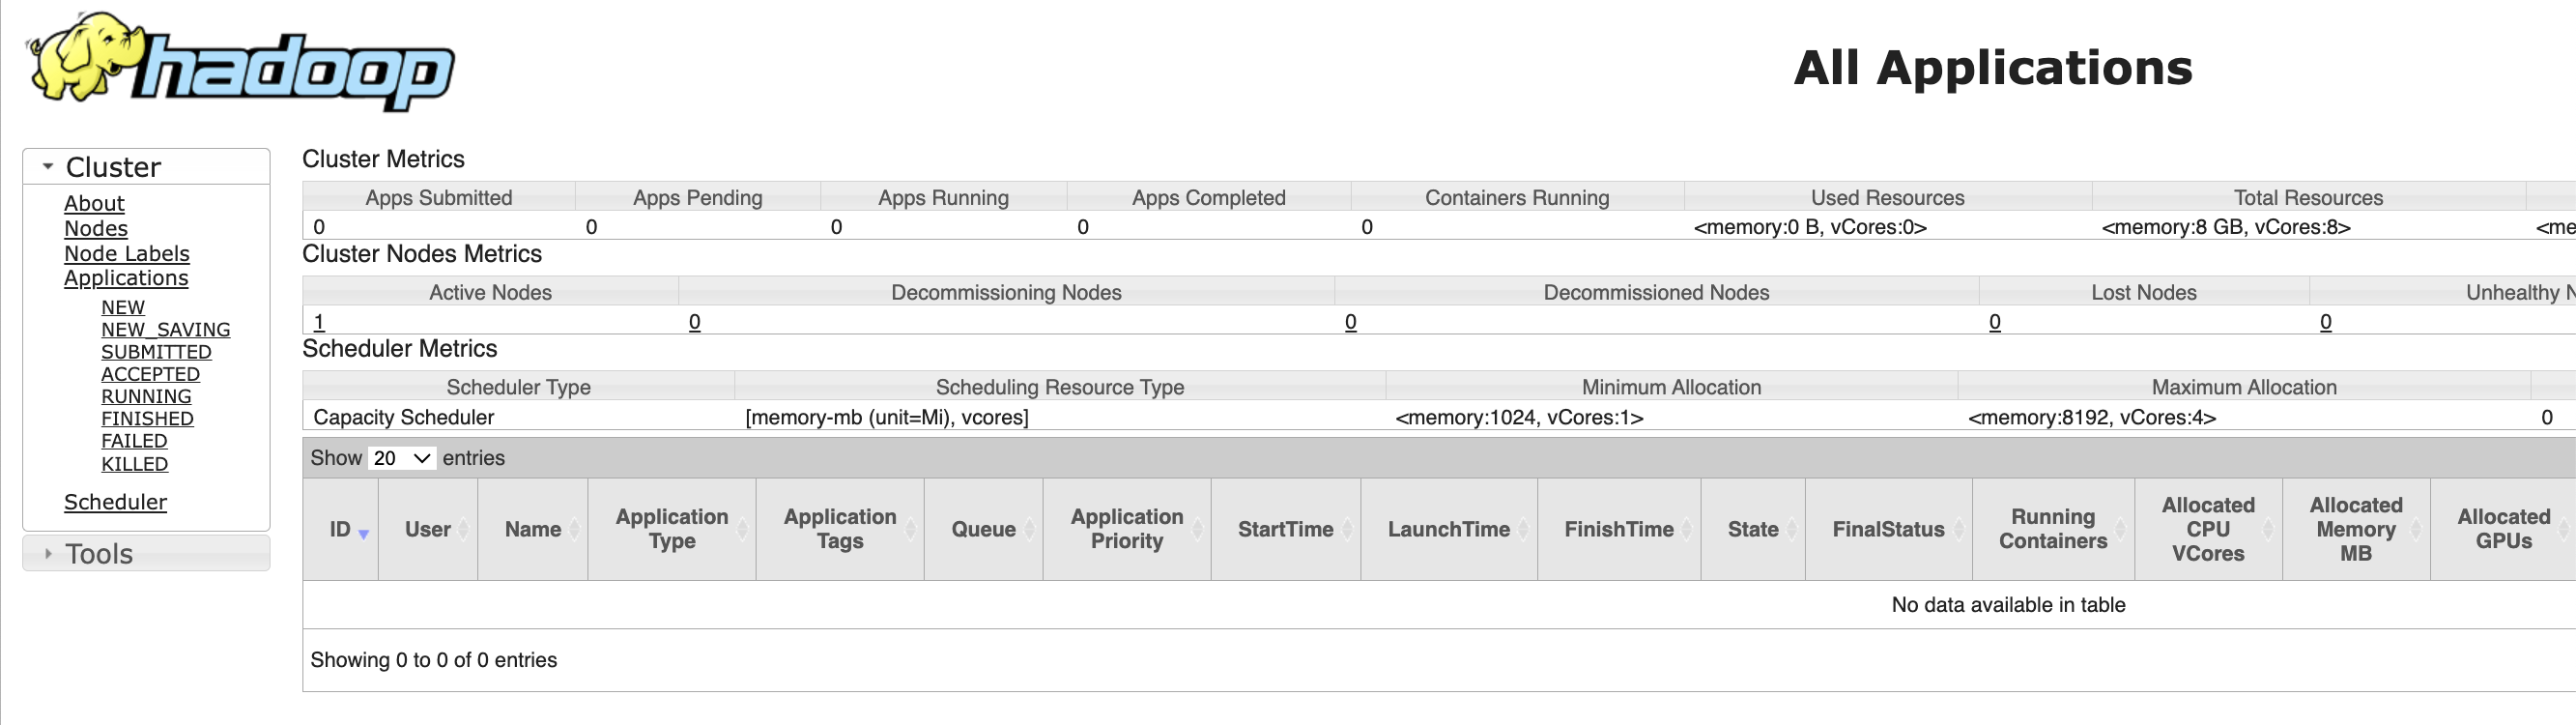
YARN Web UI: empty queue

No application is shown yet in the YARN UI since we have only ran a job locally.

Next, we want to start the History Server in order to be able to view jobs logfile when they're finished.

# Start Job History Server

As already seen, HDFS daemons are:

*   NameNode
*   SecondaryNameNode
*   DataNode

YARN daemons are:

*   ResourceManager
*   NodeManager
*   WebAppProxy.

*If MapReduce is to be used, then the MapReduce Job History Server will also be running. For large installations, these are generally running on separate hosts.*

From: [https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/ClusterSetup.html](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/ClusterSetup.html).

In [64]:
!mapred --daemon stop historyserver
!mapred --daemon start historyserver

## Start the Job History Server Web UI

In [65]:
!wget localhost:19888

--2024-04-23 18:00:21--  http://localhost:19888/
Resolving localhost (localhost)... 127.0.0.1, ::1
Connecting to localhost (localhost)|127.0.0.1|:19888... failed: Connection refused.
Connecting to localhost (localhost)|::1|:19888... failed: Cannot assign requested address.
Retrying.

--2024-04-23 18:00:22--  (try: 2)  http://localhost:19888/
Connecting to localhost (localhost)|127.0.0.1|:19888... failed: Connection refused.
Connecting to localhost (localhost)|::1|:19888... failed: Cannot assign requested address.
Retrying.

--2024-04-23 18:00:24--  (try: 3)  http://localhost:19888/
Connecting to localhost (localhost)|127.0.0.1|:19888... failed: Connection refused.
Connecting to localhost (localhost)|::1|:19888... failed: Cannot assign requested address.
Retrying.

--2024-04-23 18:00:27--  (try: 4)  http://localhost:19888/
Connecting to localhost (localhost)|127.0.0.1|:19888... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://localhost:19888/jobhistory [foll

In [66]:
if IN_COLAB:
  port = 19888
  output.serve_kernel_port_as_window(port, path='/jobhistory')

<IPython.core.display.Javascript object>

# Submit the MapReduce `pi` example to YARN

After submitting the job, you should now see the `pi` application listed in the YARN UI. Here is the link in case you closed the window or tab:

In [67]:
if IN_COLAB:
  port = 8088
  output.serve_kernel_port_as_window(port, path='/cluster')

<IPython.core.display.Javascript object>

In [68]:
!yarn jar $(find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar") pi 2 100

Number of Maps  = 2
Samples per Map = 100
Wrote input for Map #0
Wrote input for Map #1
Starting Job
2024-04-23 18:00:33,865 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at localhost/127.0.0.1:8032
2024-04-23 18:00:34,343 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1713895207884_0001
2024-04-23 18:00:34,648 INFO input.FileInputFormat: Total input files to process : 2
2024-04-23 18:00:35,167 INFO mapreduce.JobSubmitter: number of splits:2
2024-04-23 18:00:35,947 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1713895207884_0001
2024-04-23 18:00:35,947 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-04-23 18:00:36,292 INFO conf.Configuration: resource-types.xml not found
2024-04-23 18:00:36,292 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-04-23 18:00:36,880 INFO impl.YarnClientImpl: Submitted application application_1713895207884_0001
20

By refreshing the Web page, you should see the application change state from "ACCEPTED" to "RUNNING" and, finally, "FINISHED".

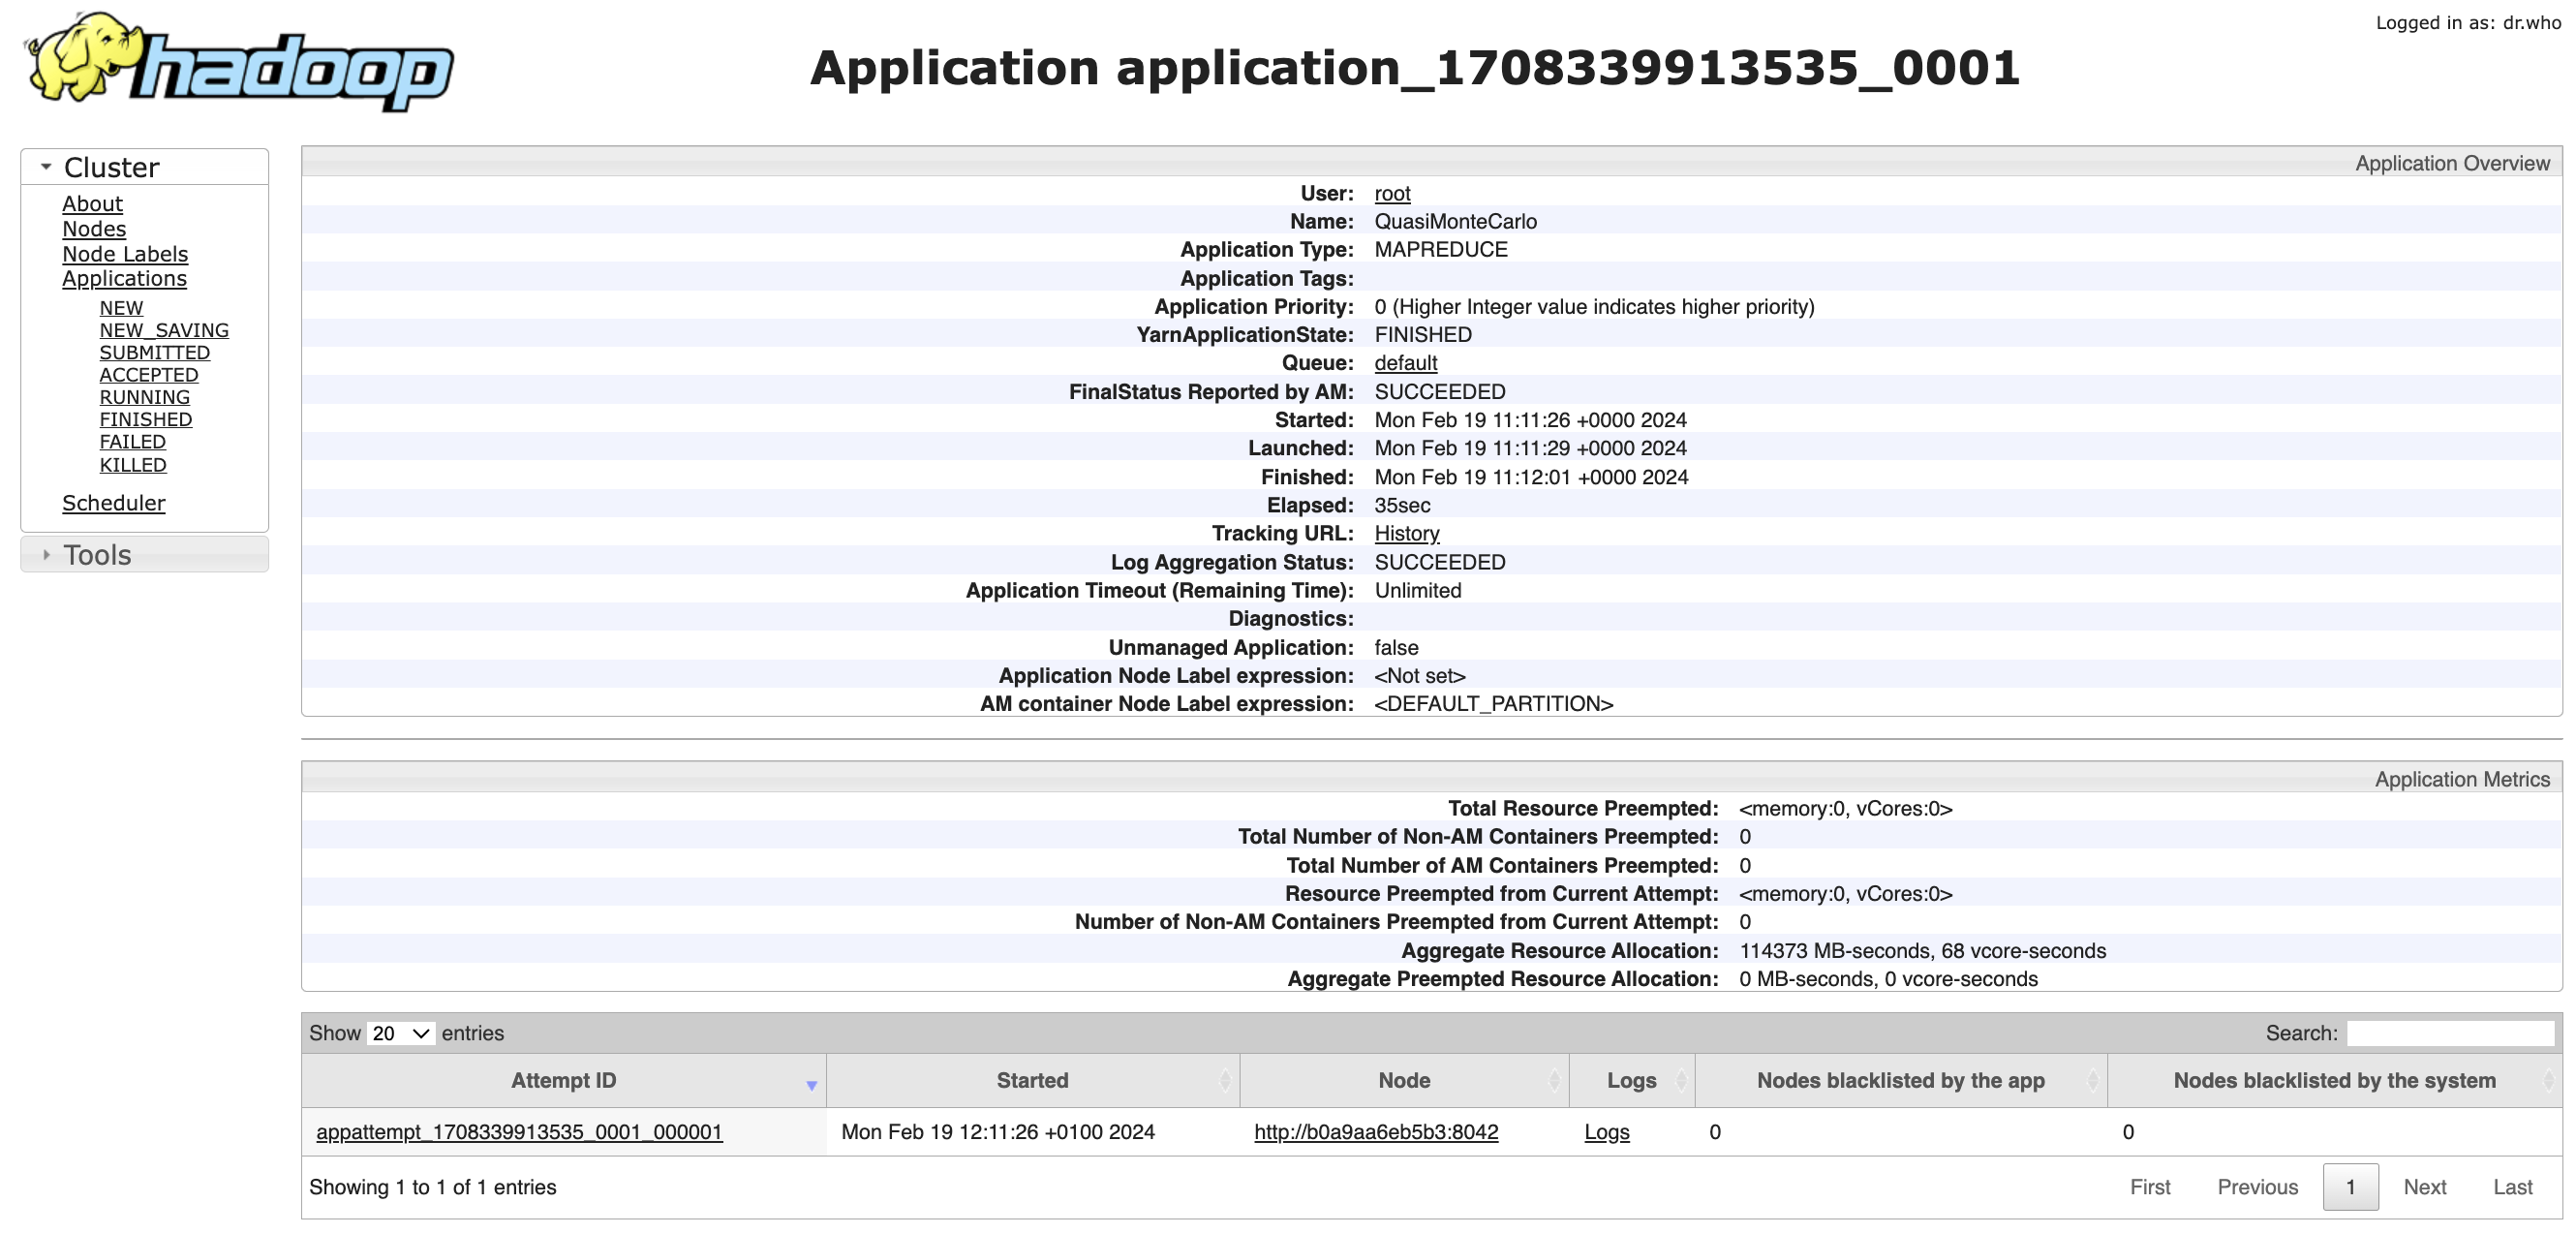
YARN Web UI: application running

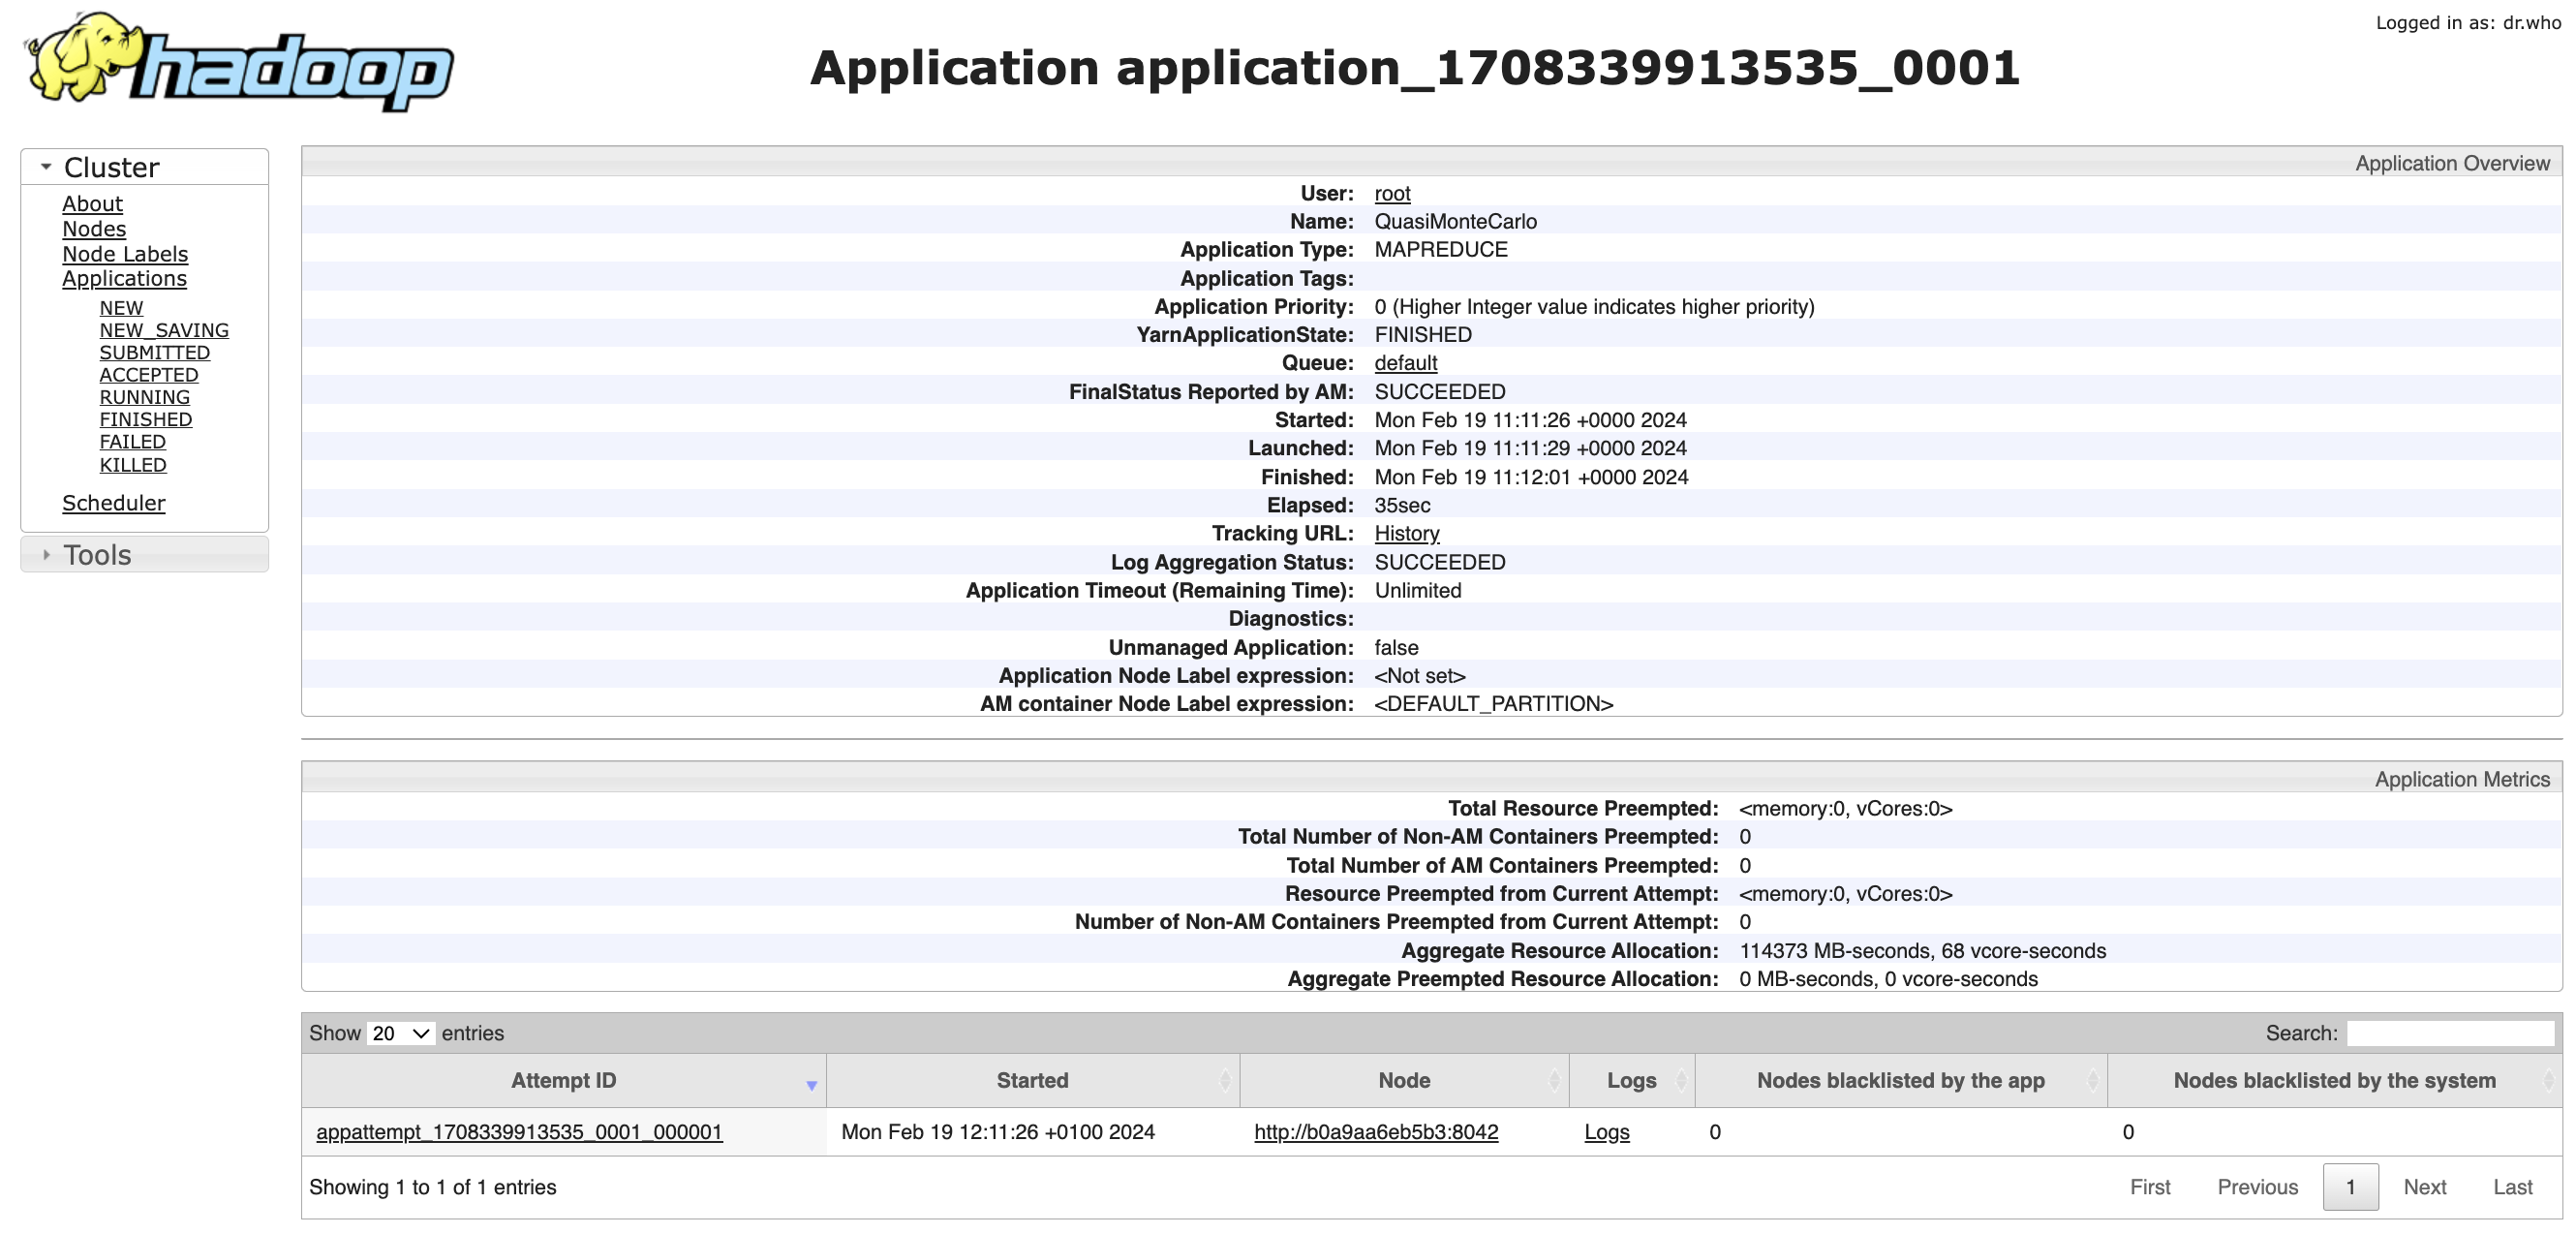
YARN Web UI: application completed

# Check Hadoop logfiles

By default, Hadoop writes logs to `$HADOOP_HOME/logs`.

In [69]:
!ls -halt $HADOOP_HOME/logs

total 548K
-rw-r--r--  1 root root  65K Apr 23 18:01 hadoop-root-resourcemanager-ac1d0ad57915.log
-rw-r--r--  1 root root 102K Apr 23 18:01 hadoop-root-namenode-ac1d0ad57915.log
-rw-r--r--  1 root root 105K Apr 23 18:01 hadoop-root-datanode-ac1d0ad57915.log
-rw-r--r--  1 root root  68K Apr 23 18:01 hadoop-root-nodemanager-ac1d0ad57915.log
-rw-r--r--  1 root root  34K Apr 23 18:00 hadoop-root-historyserver-ac1d0ad57915.log
drwxr-xr-x  3 root root 4.0K Apr 23 18:00 userlogs
-rw-r--r--  1 root root 2.9K Apr 23 18:00 hadoop-root-historyserver-ac1d0ad57915.out
drwxr-xr-x  3 root root 4.0K Apr 23 18:00 .
-rw-r--r--  1 root root 2.9K Apr 23 18:00 hadoop-root-nodemanager-ac1d0ad57915.out
-rw-r--r--  1 root root  29K Apr 23 18:00 hadoop-root-proxyserver-ac1d0ad57915.log
-rw-r--r--  1 root root 3.0K Apr 23 18:00 hadoop-root-resourcemanager-ac1d0ad57915.out
-rw-r--r--  1 root root  828 Apr 23 18:00 hadoop-root-proxyserver-ac1d0ad57915.out
-rw-r--r--  1 root root  77K Apr 23 17:59 hadoop-root-seco

This is for instance the NameNode's log.

In [70]:
!tail $HADOOP_HOME/logs/hadoop-root-namenode-*.log

2024-04-23 18:01:16,971 INFO org.apache.hadoop.hdfs.StateChange: DIR* completeFile: /tmp/hadoop-yarn/staging/root/.staging/job_1713895207884_0001/COMMIT_SUCCESS is closed by DFSClient_NONMAPREDUCE_1648160529_1
2024-04-23 18:01:17,003 INFO org.apache.hadoop.hdfs.StateChange: DIR* completeFile: /tmp/hadoop-yarn/staging/root/.staging/job_1713895207884_0001/job_1713895207884_0001_1.jhist is closed by DFSClient_NONMAPREDUCE_1648160529_1
2024-04-23 18:01:17,022 INFO org.apache.hadoop.hdfs.StateChange: BLOCK* allocate blk_1073741845_1021, replicas=127.0.0.1:9866 for /tmp/hadoop-yarn/staging/history/done_intermediate/root/job_1713895207884_0001.summary_tmp
2024-04-23 18:01:17,039 INFO org.apache.hadoop.hdfs.StateChange: DIR* completeFile: /tmp/hadoop-yarn/staging/history/done_intermediate/root/job_1713895207884_0001.summary_tmp is closed by DFSClient_NONMAPREDUCE_1648160529_1
2024-04-23 18:01:17,110 INFO org.apache.hadoop.hdfs.StateChange: BLOCK* allocate blk_1073741846_1022, replicas=127.0.0.

Show most recent error or warning messages

In [71]:
!grep "ERROR\|WARN" $HADOOP_HOME/logs/*.log | sort -r -k2 | head

/content/hadoop-3.3.6/logs/hadoop-root-nodemanager-ac1d0ad57915.log:2024-04-23 18:01:17,346 WARN org.apache.hadoop.yarn.server.nodemanager.DefaultContainerExecutor: delete returned false for path: [/tmp/hadoop-root/nm-local-dir/usercache/root/appcache/application_1713895207884_0001/container_1713895207884_0001_01_000004/sysfs]
/content/hadoop-3.3.6/logs/hadoop-root-nodemanager-ac1d0ad57915.log:2024-04-23 18:01:17,345 WARN org.apache.hadoop.yarn.server.nodemanager.DefaultContainerExecutor: delete returned false for path: [/tmp/hadoop-root/nm-local-dir/usercache/root/appcache/application_1713895207884_0001/container_1713895207884_0001_01_000004/launch_container.sh]
/content/hadoop-3.3.6/logs/hadoop-root-nodemanager-ac1d0ad57915.log:2024-04-23 18:01:17,345 WARN org.apache.hadoop.yarn.server.nodemanager.DefaultContainerExecutor: delete returned false for path: [/tmp/hadoop-root/nm-local-dir/usercache/root/appcache/application_1713895207884_0001/container_1713895207884_0001_01_000004/contai

Show most recent error messages in Hadoop logfiles.

In [72]:
!grep "ERROR" $HADOOP_HOME/logs/*.log | sort -r -k2 | head

/content/hadoop-3.3.6/logs/hadoop-root-historyserver-ac1d0ad57915.log:2024-04-23 18:00:28,621 ERROR org.apache.hadoop.yarn.logaggregation.AggregatedLogDeletionService: Error reading root log dir this deletion attempt is being aborted
/content/hadoop-3.3.6/logs/hadoop-root-secondarynamenode-ac1d0ad57915.log:2024-04-23 17:58:04,470 ERROR org.apache.hadoop.hdfs.server.namenode.SecondaryNameNode: RECEIVED SIGNAL 15: SIGTERM
/content/hadoop-3.3.6/logs/hadoop-root-datanode-ac1d0ad57915.log:2024-04-23 17:58:00,086 ERROR org.apache.hadoop.hdfs.server.datanode.DataNode: RECEIVED SIGNAL 15: SIGTERM
/content/hadoop-3.3.6/logs/hadoop-root-namenode-ac1d0ad57915.log:2024-04-23 17:57:58,798 ERROR org.apache.hadoop.hdfs.server.namenode.NameNode: RECEIVED SIGNAL 15: SIGTERM


# Stop all services

## Stop History Server

In [73]:
!mapred --daemon stop historyserver

## Stop YARN

In [74]:
!$HADOOP_HOME/sbin/stop-yarn.sh

Stopping nodemanagers
Stopping resourcemanager
Stopping proxy server [127.0.0.1]


## Stop Hadoop and `sshd` daemon

Stop Hadoop (with the command: `$HADOOP_HOME/sbin/stop-dfs.sh`) and the `sshd` daemon (with `/etc/init.d/ssh stop`).

In [75]:
subprocess_output = subprocess.run([os.path.join(os.environ['HADOOP_HOME'], 'sbin', 'stop-dfs.sh')], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

Stopping namenodes on [localhost]
Stopping datanodes
Stopping secondary namenodes [ac1d0ad57915]



In [76]:
subprocess_output = subprocess.run(['/etc/init.d/ssh', 'stop'], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

 * Stopping OpenBSD Secure Shell server sshd
   ...done.



# Restart and play

If you've come so far by running all cells in the notebook from the menu (and not interactively) you can re-start Hadoop by issuing the following commands:

In [77]:
# start the ssh daemon
logger.info("Starting {}".format("openssh-server"))
cmd = ["/etc/init.d/ssh", "restart"]
result = subprocess.check_output(cmd, stderr=subprocess.STDOUT)
!ssh localhost "echo hi!"

# start HDFS
logger.info("Starting HDFS")
subprocess_output = subprocess.run([os.path.join(os.environ['HADOOP_HOME'], 'sbin', 'start-dfs.sh')], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

23-Apr-24 06:01:44 PM - INFO: Starting openssh-server


hi!


23-Apr-24 06:01:44 PM - INFO: Starting HDFS


Starting namenodes on [localhost]
Starting datanodes
Starting secondary namenodes [ac1d0ad57915]



In [78]:
%%bash
counter=0
until [ $counter -gt 20 ]
do
  ((counter++))
  sleep 1
  # counting lines, exclude header and jupyter port 9000
  if [ $(lsof -n -i -P +c0 -sTCP:LISTEN -ac java| wc -l ) -ge 8 ] && \
  [ $(lsof -n -aiTCP:9870 -aiTCP:9000 -aiTCP:9864 -aiTCP:9866 -aiTCP:9867 -aiTCP:9868 -P +c0 -sTCP:LISTEN -ac java | wc -l) -eq 7 ]
  then
   echo "HDFS is up and running"
   echo "Time to start: $counter secs"
   exit
  fi
done
echo "Some HDFS ports are missing. Wait some more or restart HDFS."

HDFS is up and running
Time to start: 1 secs


In [79]:
# start YARN
logger.info("Starting YARN")
!$HADOOP_HOME/sbin/start-yarn.sh

23-Apr-24 06:02:14 PM - INFO: Starting YARN


Starting resourcemanager
Starting nodemanagers


In [80]:
# wait for YARN services to start listening
%%bash
counter=0
until [ $counter -gt 20 ]
do
  ((counter++))
  sleep 1
  # counting lines + header
  if [ $(lsof -n -aiTCP:8088 -aiTCP:8030 -aiTCP:8031 -aiTCP:8032 -aiTCP:8033 -aiTCP:8042 -aiTCP:3141 -P +c0 -sTCP:LISTEN -ac java |wc -l ) -eq 8 ]
  then
   echo "YARN is up and running"
   echo "Time to start: $counter secs"
   exit
  fi
done
echo "Some YARN ports are missing. Wait some more or restart YARN."

YARN is up and running
Time to start: 4 secs


In [81]:
# start History Server
!mapred --daemon start historyserver

In [82]:
# Web UIs
if IN_COLAB:
  # NameNode
  output.serve_kernel_port_as_window(9870, path='/index.html')
  # YARN
  output.serve_kernel_port_as_window(8088, path='/cluster')
  # Job History Server
  output.serve_kernel_port_as_window(19888, path='/jobhistory')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Run the `pi` app again.

In [83]:
!yarn jar $(find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar") pi 2 100

Number of Maps  = 2
Samples per Map = 100
Wrote input for Map #0
Wrote input for Map #1
Starting Job
2024-04-23 18:03:01,154 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at localhost/127.0.0.1:8032
2024-04-23 18:03:02,465 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1713895362108_0001
2024-04-23 18:03:03,054 INFO input.FileInputFormat: Total input files to process : 2
2024-04-23 18:03:03,680 INFO mapreduce.JobSubmitter: number of splits:2
2024-04-23 18:03:04,521 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1713895362108_0001
2024-04-23 18:03:04,521 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-04-23 18:03:05,039 INFO conf.Configuration: resource-types.xml not found
2024-04-23 18:03:05,040 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-04-23 18:03:05,607 INFO impl.YarnClientImpl: Submitted application application_1713895362108_0001
20

In [84]:
print('Long Tri Thai Son')

Long Tri Thai Son
